In [1]:
import warnings
from pathlib import Path

import cartopy.crs as ccrs
import iris
import iris.analysis
import iris.coord_categorisation
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
from scipy import stats
from tqdm.notebook import tqdm

In [32]:
def m_to_km(x, pos):
    """Convert meters to kilometers when plotting axis labels"""
    return int(x * 1e-3)

In [2]:
from aeolus.coord import add_cyclic_point_to_cube, replace_z_coord
from aeolus.plot import subplot_label_generator

In [3]:
from util_commons import EXPERIMENTS, GASES, LAYERS, SEASONS
from util_mypaths import path_to_processed, path_to_results
from util_plot_func import use_paper_style
from util_proc_func import fdr_threshold, mmr_to_vmr_in_ppn

In [4]:
warnings.filterwarnings("ignore", module="iris")
use_paper_style()

In [5]:
# Switches
ctrl = "CTRL"
layer = "BL"  # BL or FT # add layer as a dict key
w_rono2 = True

In [6]:
# List of chemical species to compute
SPECIES = [
    "ch4",
    "c2h6",
    "c3h8",
    "no",
    "no2",
    "hono",
    "ho2no2",
    "hno3",
    "n2o5",
    "pan",
    "ppan",
    "meono2",
    "etono2",
    "nprono2",
    "iprono2",
    "o3",
]

In [7]:
# Read data
vrbls = {}
for exp in EXPERIMENTS.keys():
    vrbls[exp] = {}
    for sp in SPECIES:
        cube_in_mmr = iris.load_cube(
            str(path_to_processed / EXPERIMENTS[exp] / f"{EXPERIMENTS[exp]}_{sp}.nc"), sp
        )
        # Convert mass mixing ratio to volume mixing ratio
        cube_in_vmr = mmr_to_vmr_in_ppn(cube_in_mmr, GASES[sp]["molar_mass"], GASES[sp]["ppn"])
        # Replace model_level_number coordinate with level_height coordinate
        cube_on_hlevs = replace_z_coord(cube_in_vmr)
        cube_on_hlevs.rename(sp)
        cube_on_hlevs.units = GASES[sp]["ppn"]
        # Remove the first year as a spin up
        cube_on_hlevs = cube_on_hlevs[24::, ...]
        # Add season and year coordinates
        iris.coord_categorisation.add_season(cube_on_hlevs, "time", name="season")
        iris.coord_categorisation.add_season_year(cube_on_hlevs, "time", name="year")
        vrbls[exp][sp] = cube_on_hlevs

In [8]:
# Calculate NOx and NOy
for exp in EXPERIMENTS.keys():
    nox_raw = vrbls[exp]["no"] + vrbls[exp]["no2"]
    noy_raw = (
        nox_raw
        + vrbls[exp]["hono"]
        + vrbls[exp]["ho2no2"]
        + vrbls[exp]["hno3"]
        + vrbls[exp]["n2o5"]
        + vrbls[exp]["pan"]
        + vrbls[exp]["ppan"]
    )
    # Include RONO2 into NOy
    if w_rono2:
        rono2_raw = (
            vrbls[exp]["meono2"]
            + vrbls[exp]["etono2"]
            + vrbls[exp]["nprono2"]
            + vrbls[exp]["iprono2"]
        )
        rono2_raw.convert_units("ppbv")
        noy_raw = noy_raw + rono2_raw
    nox_raw.rename("nox")
    noy_raw.rename("noy")
    nox_raw.units = "ppbv"
    noy_raw.units = "ppbv"
    vrbls[exp]["nox"] = nox_raw
    vrbls[exp]["noy"] = noy_raw

### Boundary layer seasonal means

In [ ]:
# Calculate 9-year-average seasonal mean in a specified atmospheric layer
VRBLS = {}
for exp in EXPERIMENTS.keys():
    VRBLS[exp] = {}
    for var in ["o3", "nox", "noy"]:  # vrbls[exp].keys():
        VRBLS[exp][var] = {}
        for ssn in SEASONS:
            # Extract a time series for each latitude-longitude within the specified layer by season
            # and average each time slice in height
            ssn_constr = iris.Constraint(season=ssn)
            ssn_ts = (
                vrbls[exp][var]
                .extract(LAYERS["0-2km"]["iris_constr"] & ssn_constr)
                .collapsed(["level_height"], iris.analysis.MEAN)
            )
            # Calculate 9-year-average seasonal mean
            _ssn_mean = ssn_ts.collapsed("year", iris.analysis.MEAN)
            # Add a cyclic point for plotting
            ssn_mean = add_cyclic_point_to_cube(_ssn_mean)
            # Find minimum and maximum
            ssn_mean_min, ssn_mean_max = ssn_mean.data.min(), ssn_mean.data.max()
            # Assemble the data
            VRBLS[exp][var][ssn] = {
                "ssn_ts": ssn_ts,
                "ssn_mean": ssn_mean,
                "ssn_mean_min": ssn_mean_min,
                "ssn_mean_max": ssn_mean_max,
            }

In [308]:
def calc_mean_diff_pval(cube_ctrl, cube_sens, pval_thresh=0.05):
    """Find if the mean difference in the chemical species abundance between the control and sensitivity experiment is statisticaly significant.

    1. Check if the data are normally distributed using the Shapiro–Wilk test.
    2. If the data are normally distributed, use a paired sample t-test, and if not, use the Wilcoxon signed-rank test.
    cube_ctrl and cube_sens must contain 9-year-average seasonal means in a specified atmospheric layer for each latitude-longitude.

    Parameters
    ----------
    cube_ctrl: iris.cube.Cube
        Cube with the data from the control experiment.
    cube_sens: iris.cube.Cube
        Cube with the data from the sensitivity experiment.
    pval_thresh: float, optional
        p-value threshold.

    Returns
    -------
    iris.cube.Cube
        Cube of p-values.
    """
    result_cube_dummy = next(cube_ctrl.slices_over("time"))
    nlats, nlons = result_cube_dummy.shape
    pval_arr = np.empty([nlats, nlons])
    for j in range(nlats):
        for i in range(nlons):
            shapiro_pval = stats.shapiro(cube_ctrl.data[:, j, i] - cube_sens.data[:, j, i])[1]
            if shapiro_pval > pval_thresh:
                pval_arr[j, i] = stats.ttest_rel(cube_ctrl.data[:, j, i], cube_sens.data[:, j, i])[
                    1
                ]
            else:
                pval_arr[j, i] = stats.wilcoxon(cube_ctrl.data[:, j, i], cube_sens.data[:, j, i])[1]
    cube_out = result_cube_dummy.copy(data=pval_arr)
    cube_out.rename("p-value")
    cube_out.units = 1
    return cube_out


def stipple_out(cube_pval, fdr_on=True):
    """Stipple areas where the mean difference in the chemical species abundance between the control and sensitivity experiment is not statisticaly significant.

    Parameters
    ----------
    cube_pval: iris.cube.Cube
        Cube of p-values.
    fdr_on: bool
        Use the false discovery rate threshold instead of the original p-value.

    Returns
    -------
    tuple
        Coordinates to stipple out.
    """
    coord_points = [c.points for c in cube_pval.dim_coords]
    mesh_grids = np.meshgrid(*coord_points[::-1])
    if fdr_on:
        thresh = fdr_threshold(cube_pval.data)
    else:
        thresh = 0.05
    sig_points = cube_pval.data > thresh
    sig_coord_points = [arr[sig_points] for arr in mesh_grids]
    return sig_coord_points

In [312]:
def stipple_out_explicit(cube_pval, fdr_on=True):
    """Stipple areas where the mean difference in the chemical species abundance between the control and sensitivity experiment is not statisticaly significant.

    Parameters
    ----------
    cube_pval: iris.cube.Cube
        Cube of p-values.
    fdr_on: bool
        Use the false discovery rate threshold instead of the original p-value.

    Returns
    -------
    tuple
        Coordinates to stipple out.
    """
    dim_coord_names = [c.name() for c in cube_pval.dim_coords]
    if "level_height" in dim_coord_names and "latitude" in dim_coord_names:
        xx, yy = np.meshgrid(cube_pval.coord("latitude").points, cube_pval.coord("level_height").points)
    elif "longitude" in dim_coord_names and "latitude" in dim_coord_names:
        xx, yy = np.meshgrid(cube_pval.coord("longitude").points, cube_pval.coord("latitude").points)
    if fdr_on:
        thresh = fdr_threshold(cube_pval.data)
    else:
        thresh = 0.05
    sig_points = cube_pval.data > thresh
    xxp = xx[sig_points]
    yyp = yy[sig_points]
    return (xxp, yyp)

In [309]:
aa, bb = stipple_out(VRBLS[sens][var][ssn]["pval"])

In [311]:
aa, bb

(array([-47.5, -45. , -42.5, ...,  85. ,  87.5,  90. ], dtype=float32),
 array([   19.998281,    19.998281,    19.998281, ..., 16820.002   ,
        16820.002   , 16820.002   ], dtype=float32))

In [313]:
cc, dd = stipple_out_explicit(VRBLS[sens][var][ssn]["pval"])

In [305]:
VRBLS[sens][var][ssn]["pval"].dim_coords

(DimCoord(array([   19.998281,    80.00153 ,   180.00136 ,   319.99774 ,
          499.99908 ,   719.997   ,   979.9999  ,  1279.9994  ,
         1620.0038  ,  1999.9963  ,  2420.0022  ,  2879.9963  ,
         3380.004   ,  3919.9995  ,  4500.      ,  5119.9976  ,
         5779.9995  ,  6479.998   ,  7220.002   ,  8000.002   ,
         8819.999   ,  9680.001   , 10579.999   , 11520.002   ,
        12500.002   , 13519.999   , 14580.      , 15679.998   ,
        16820.002   ], dtype=float32), bounds=array([[-1.0003344e+01,  4.9999908e+01],
        [ 4.9999908e+01,  1.3000145e+02],
        [ 1.3000145e+02,  2.4999954e+02],
        [ 2.4999954e+02,  4.0999841e+02],
        [ 4.0999841e+02,  6.0999805e+02],
        [ 6.0999805e+02,  8.4999841e+02],
        [ 8.4999841e+02,  1.1299996e+03],
        [ 1.1299996e+03,  1.4500016e+03],
        [ 1.4500016e+03,  1.8100000e+03],
        [ 1.8100000e+03,  2.2099993e+03],
        [ 2.2099993e+03,  2.6499993e+03],
        [ 2.6499993e+03,  3.1300000e

In [303]:
for i in VRBLS[sens][var][ssn]["pval"].coords:

TypeError: 'method' object is not iterable

In [ ]:
# Calculate seasonal mean differences and their statistical significance
for sens in [k for k in EXPERIMENTS.keys() if k != "CTRL"]:
    for var in tqdm(VRBLS["CTRL"].keys()):
        for ssn in tqdm(SEASONS, leave=False):
            ssn_mean_diff_abs = (
                VRBLS[sens][var][ssn]["ssn_mean"] - VRBLS[ctrl][var][ssn]["ssn_mean"]
            )
            ssn_mean_diff_pct = ssn_mean_diff_abs / VRBLS[ctrl][var][ssn]["ssn_mean"] * 100
            ssn_mean_diff_abs_min, ssn_mean_diff_abs_max = (
                ssn_mean_diff_abs.data.min(),
                ssn_mean_diff_abs.data.max(),
            )
            ssn_mean_diff_pct_min, ssn_mean_diff_pct_max = (
                ssn_mean_diff_pct.data.min(),
                ssn_mean_diff_pct.data.max(),
            )
            pval = calc_mean_diff_pval(VRBLS[ctrl][var][ssn]["ssn_ts"], VRBLS[sens][var][ssn]["ssn_ts"])
            # Assemble the data
            VRBLS[sens][var][ssn] = {
                "ssn_mean_diff_abs": ssn_mean_diff_abs,
                "ssn_mean_diff_pct": ssn_mean_diff_pct,
                "pval": pval,
                "ssn_mean_diff_abs_min": ssn_mean_diff_abs_min,
                "ssn_mean_diff_abs_max": ssn_mean_diff_abs_max,
                "ssn_mean_diff_pct_min": ssn_mean_diff_pct_min,
                "ssn_mean_diff_pct_max": ssn_mean_diff_pct_max,
            }

In [ ]:
# Find common extrema
var_lims = {}
for var in ["o3", "nox", "noy"]:
    var_lims[var] = {}
    ssn_mean_min_com = []
    ssn_mean_max_com = []
    ssn_mean_diff_abs_min_com = []
    ssn_mean_diff_abs_max_com = []
    ssn_mean_diff_pct_min_com = []
    ssn_mean_diff_pct_max_com = []
    for ssn in SEASONS:
        ssn_mean_min_com.append(VRBLS[ctrl][var][ssn]["ssn_mean_min"])
        ssn_mean_max_com.append(VRBLS[ctrl][var][ssn]["ssn_mean_max"])
        for sens in [k for k in EXPERIMENTS.keys() if k != "CTRL"]:
            ssn_mean_diff_abs_min_com.append(VRBLS[sens][var][ssn]["ssn_mean_diff_abs_min"])
            ssn_mean_diff_abs_max_com.append(VRBLS[sens][var][ssn]["ssn_mean_diff_abs_max"])
            ssn_mean_diff_pct_min_com.append(VRBLS[sens][var][ssn]["ssn_mean_diff_pct_min"])
            ssn_mean_diff_pct_max_com.append(VRBLS[sens][var][ssn]["ssn_mean_diff_pct_max"])
    var_lims[var] = {
        "ssn_mean_min_com": np.min(ssn_mean_min_com),
        "ssn_mean_max_com": np.max(ssn_mean_max_com),
        "ssn_mean_diff_abs_min_com": np.min(ssn_mean_diff_abs_min_com),
        "ssn_mean_diff_abs_max_com": np.max(ssn_mean_diff_abs_max_com),
        "ssn_mean_diff_pct_min_com": np.min(ssn_mean_diff_pct_min_com),
        "ssn_mean_diff_pct_max_com": np.max(ssn_mean_diff_pct_max_com),
    }

In [ ]:
def plt_ssn_maps(var, ctrl_dict, sens_dict):
    """Plot"""
    iletters = subplot_label_generator()

    lons = ctrl_dict[var]["djf"]["ssn_mean"].coord("longitude").points
    lats = ctrl_dict[var]["djf"]["ssn_mean"].coord("latitude").points

    if var == "o3":
        ssn_mean_levs = np.arange(0, 110, 10)
        ssn_mean_diff_abs_levs = np.arange(-10, 12, 2)
        ssn_mean_diff_pct_levs = np.arange(-40, 50, 10)
    elif var == "nox":
        ssn_mean_levs = np.arange(-4, 3, 1)
        ssn_mean_diff_abs_levs = np.arange(-1.25, 1.50, 0.25)
        ssn_mean_diff_pct_levs = np.arange(-200, 220, 20)

    map_kws = dict(transform=ccrs.PlateCarree())
    cax_kw = dict(orientation="horizontal")
    ssn_mean_kws = dict(cmap="viridis", levels=ssn_mean_levs, **map_kws)
    ssn_mean_diff_abs_kws = dict(cmap="RdBu_r", levels=ssn_mean_diff_abs_levs, **map_kws)
    ssn_mean_diff_pct_kws = dict(cmap="RdBu_r", levels=ssn_mean_diff_pct_levs, **map_kws)
    pval_kws = dict(s=1, c="grey", marker=".", alpha=1, **map_kws)

    fig, ax = plt.subplots(
        nrows=4,
        ncols=3,
        figsize=(20, 20),
        subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)),
        facecolor="w",
    )
    for ssn, iax in zip(SEASONS, ax[:, 0].flatten()):
        if var == "o3":
            p0 = iax.contourf(lons, lats, ctrl_dict[var][ssn]["ssn_mean"].data, **ssn_mean_kws)
        else:
            ctrl_ssn_mean = iris.analysis.maths.log10(
                ctrl_dict[var][ssn]["ssn_mean"], in_place=False
            )
            p0 = iax.contourf(
                lons,
                lats,
                ctrl_ssn_mean.data,
                **ssn_mean_kws,
            )
        if iax.is_first_row():
            iax.set_title(ctrl, loc="center", weight="bold")
        iax.annotate(f"         {ssn.upper()}", xy=(0, 1), xycoords="axes fraction", weight="bold")

    for ssn, iax in zip(SEASONS, ax[:, 1].flatten()):
        p1 = iax.contourf(
            lons, lats, sens_dict[var][ssn]["ssn_mean_diff_abs"].data, **ssn_mean_diff_abs_kws
        )
        iax.scatter(*stipple_out_xy(sens_dict[var][ssn]["pval"], True), **pval_kws)

    for ssn, iax in zip(SEASONS, ax[:, 2].flatten()):
        p2 = iax.contourf(
            lons, lats, sens_dict[var][ssn]["ssn_mean_diff_pct"].data, **ssn_mean_diff_pct_kws
        )
        iax.scatter(*stipple_out_xy(sens_dict[var][ssn]["pval"], True), **pval_kws)

    for iax in ax[0, 1:3].flatten():
        iax.set_title(f"{sens} - {ctrl}", loc="center", weight="bold")
    for iax in ax.flatten():
        iax.set_title(f"({next(iletters)})", loc="left")
        iax.set_global()
        iax.coastlines()
    fig.subplots_adjust(hspace=-0.6, wspace=0.02)
    cax0 = fig.add_axes([0.185, 0.22, 0.135, 0.005])  # [left, bottom, width, height]
    cax1 = fig.add_axes([0.446, 0.22, 0.135, 0.005])
    cax2 = fig.add_axes([0.706, 0.22, 0.135, 0.005])
    cbar0 = fig.colorbar(p0, cax=cax0, label=f"{GASES[var]['tex']} [{GASES[var]['ppn']}]", **cax_kw)
    if var == "nox":
        cbar0.ax.set_xticklabels(
            ["$10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^0$", "$10^1$", "$10^2$"]
        )
    fig.colorbar(p1, cax=cax1, label=f"$\Delta${GASES[var]['tex']} [{GASES[var]['ppn']}]", **cax_kw)
    fig.colorbar(p2, cax=cax2, label=f"$\Delta${GASES[var]['tex']} [%]", **cax_kw)
    fig.suptitle(LAYERS[layer]["tex"], x=0.5125, y=0.8, weight="bold")
    fig.savefig(
        path_to_results / "xojn" / "ssn_mean_diff_xy" / f"{sens.lower()}_{ctrl.lower()}_{var}_ssn_mean_diff_xy_{layer}.png"
    )

In [ ]:
# ctrl_dict = VRBLS[ctrl]
# for sens in [k for k in EXPERIMENTS.keys() if k != "CTRL"]:
#     for var in ["o3", "nox"]:
#         sens_dict = VRBLS[sens]
#         plt_ssn_maps(var, ctrl_dict, sens_dict)

In [ ]:
break

### Zonal seasonal means

In [ ]:
# Choose layer
layer = "0-17km"

In [169]:
# Calculate 9-year-average zonal seasonal mean
VRBLS = {}
for exp in EXPERIMENTS.keys():
    VRBLS[exp] = {}
    for var in ["o3", "nox", "noy"]:  # vrbls[exp].keys():
        VRBLS[exp][var] = {}
        for ssn in SEASONS:
            # Extract a time series for each latitude-longitude within the specified layer by season
            # and average each time slice in longitude
            ssn_constr = iris.Constraint(season=ssn)
            ssn_ts = (
                vrbls[exp][var]
                .extract(LAYERS[layer]["iris_constr"] & ssn_constr)
                .collapsed(["longitude"], iris.analysis.MEAN)
            )
            # Calculate 9-year-average seasonal mean
            ssn_mean = ssn_ts.collapsed("year", iris.analysis.MEAN)
            # Find minimum and maximum
            ssn_mean_min, ssn_mean_max = ssn_mean.data.min(), ssn_mean.data.max()
            # Assemble the data
            VRBLS[exp][var][ssn] = {
                "ssn_ts": ssn_ts,
                "ssn_mean": ssn_mean,
                "ssn_mean_min": ssn_mean_min,
                "ssn_mean_max": ssn_mean_max,
            }

In [170]:
# Calculate seasonal mean differences and their statistical significance
for sens in [k for k in EXPERIMENTS.keys() if k != "CTRL"]:
    for var in tqdm(VRBLS["CTRL"].keys()):
        for ssn in tqdm(SEASONS, leave=False):
            ssn_mean_diff_abs = (
                VRBLS[sens][var][ssn]["ssn_mean"] - VRBLS[ctrl][var][ssn]["ssn_mean"]
            )
            ssn_mean_diff_pct = ssn_mean_diff_abs / VRBLS[ctrl][var][ssn]["ssn_mean"] * 100
            ssn_mean_diff_abs_min, ssn_mean_diff_abs_max = (
                ssn_mean_diff_abs.data.min(),
                ssn_mean_diff_abs.data.max(),
            )
            ssn_mean_diff_pct_min, ssn_mean_diff_pct_max = (
                ssn_mean_diff_pct.data.min(),
                ssn_mean_diff_pct.data.max(),
            )
            pval = calc_mean_diff_pval(VRBLS[ctrl][var][ssn]["ssn_ts"], VRBLS[sens][var][ssn]["ssn_ts"])
            # Assemble the data
            VRBLS[sens][var][ssn] = {
                "ssn_mean_diff_abs": ssn_mean_diff_abs,
                "ssn_mean_diff_pct": ssn_mean_diff_pct,
                "pval": pval,
                "ssn_mean_diff_abs_min": ssn_mean_diff_abs_min,
                "ssn_mean_diff_abs_max": ssn_mean_diff_abs_max,
                "ssn_mean_diff_pct_min": ssn_mean_diff_pct_min,
                "ssn_mean_diff_pct_max": ssn_mean_diff_pct_max,
            }

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [172]:
# Find common extrema
var_lims = {}
for var in ["o3", "nox", "noy"]:
    var_lims[var] = {}
    ssn_mean_min_com = []
    ssn_mean_max_com = []
    ssn_mean_diff_abs_min_com = []
    ssn_mean_diff_abs_max_com = []
    ssn_mean_diff_pct_min_com = []
    ssn_mean_diff_pct_max_com = []
    for ssn in SEASONS:
        ssn_mean_min_com.append(VRBLS[ctrl][var][ssn]["ssn_mean_min"])
        ssn_mean_max_com.append(VRBLS[ctrl][var][ssn]["ssn_mean_max"])
        for sens in [k for k in EXPERIMENTS.keys() if k != "CTRL"]:
            ssn_mean_diff_abs_min_com.append(VRBLS[sens][var][ssn]["ssn_mean_diff_abs_min"])
            ssn_mean_diff_abs_max_com.append(VRBLS[sens][var][ssn]["ssn_mean_diff_abs_max"])
            ssn_mean_diff_pct_min_com.append(VRBLS[sens][var][ssn]["ssn_mean_diff_pct_min"])
            ssn_mean_diff_pct_max_com.append(VRBLS[sens][var][ssn]["ssn_mean_diff_pct_max"])
    var_lims[var] = {
        "ssn_mean_min_com": np.min(ssn_mean_min_com),
        "ssn_mean_max_com": np.max(ssn_mean_max_com),
        "ssn_mean_diff_abs_min_com": np.min(ssn_mean_diff_abs_min_com),
        "ssn_mean_diff_abs_max_com": np.max(ssn_mean_diff_abs_max_com),
        "ssn_mean_diff_pct_min_com": np.min(ssn_mean_diff_pct_min_com),
        "ssn_mean_diff_pct_max_com": np.max(ssn_mean_diff_pct_max_com),
    }

In [173]:
var_lims["o3"]

{'ssn_mean_min_com': 7.394688,
 'ssn_mean_max_com': 2129.7175,
 'ssn_mean_diff_abs_min_com': -147.3183,
 'ssn_mean_diff_abs_max_com': 356.6587,
 'ssn_mean_diff_pct_min_com': -29.272451,
 'ssn_mean_diff_pct_max_com': 33.974907}

In [174]:
var_lims["nox"]

{'ssn_mean_min_com': 5.5527294e-06,
 'ssn_mean_max_com': 3.3623092,
 'ssn_mean_diff_abs_min_com': -0.13005638,
 'ssn_mean_diff_abs_max_com': 0.32683635,
 'ssn_mean_diff_pct_min_com': -77.92294,
 'ssn_mean_diff_pct_max_com': 187.14474}

In [289]:
def plt_ssn_cross_section(var, layer, ctrl_dict, sens_dict):
    """Plot"""
    iletters = subplot_label_generator()

    levs = ctrl_dict[var]["djf"]["ssn_mean"].coord("level_height").points
    lats = ctrl_dict[var]["djf"]["ssn_mean"].coord("latitude").points

    if var == "o3":
        if layer in ["0-30km", "0-85km"]:
            ssn_mean_levs = np.arange(0, 12000, 1000)
            ssn_mean_diff_abs_levs = np.arange(-1000, 1200, 200)
            ssn_mean_diff_pct_levs = np.arange(-50, 60, 10)
        elif layer == "0-17km":
            ssn_mean_levs = np.arange(0, 130, 10)
            ssn_mean_diff_abs_levs = np.arange(-5, 5.5, 0.5)
            ssn_mean_diff_pct_levs = np.arange(-20, 22, 2)
    elif var == "nox":
        if layer in ["0-30km", "0-85km"]:
            ssn_mean_levs = np.arange(-6, 3, 1)
            ssn_mean_diff_abs_levs = np.arange(-1.25, 1.50, 0.25)
            ssn_mean_diff_pct_levs = np.arange(-250, 300, 50)
        elif layer == "0-17km":
            ssn_mean_levs = np.arange(-6, 1.5, 0.5)
            ssn_mean_diff_abs_levs = np.arange(-0.05, 0.06, 0.01)
            ssn_mean_diff_pct_levs = np.arange(-200, 220, 20)

    cax_kw = dict(orientation="horizontal")
    ssn_mean_kws = dict(cmap="viridis", levels=ssn_mean_levs, extend="max")
    ssn_mean_diff_abs_kws = dict(cmap="RdBu_r", levels=ssn_mean_diff_abs_levs, extend="both")
    ssn_mean_diff_pct_kws = dict(cmap="RdBu_r", levels=ssn_mean_diff_pct_levs, extend="both")
    pval_kws = dict(s=5, c="grey", marker=".", alpha=1)

    fig, ax = plt.subplots(
        nrows=4, ncols=3, figsize=(20, 20), facecolor="w", sharex=True, sharey=True
    )
    for ssn, iax in zip(SEASONS, ax[:, 0].flatten()):
        if var == "o3":
            p0 = iax.contourf(lats, levs, ctrl_dict[var][ssn]["ssn_mean"].data, **ssn_mean_kws)
        else:
            ctrl_ssn_mean = iris.analysis.maths.log10(
                ctrl_dict[var][ssn]["ssn_mean"], in_place=False
            )
            p0 = iax.contourf(
                lats,
                levs,
                ctrl_ssn_mean.data,
                **ssn_mean_kws,
            )
        if iax.is_first_row():
            iax.set_title(ctrl, loc="center", weight="bold")
        iax.set_ylabel("Height [km]")
        iax.annotate(f"      {ssn.upper()}", xy=(0, 1.025), xycoords="axes fraction", weight="bold")

    for ssn, iax in zip(SEASONS, ax[:, 1].flatten()):
        p1 = iax.contourf(
            lats,
            levs,
            np.ma.masked_where(
                ctrl_dict["o3"][ssn]["ssn_mean"].data >= 120,
                sens_dict[var][ssn]["ssn_mean_diff_abs"].data,
            ),
            **ssn_mean_diff_abs_kws,
        )
        iax.scatter(*stipple_out_yz(sens_dict[var][ssn]["pval"], True), **pval_kws)

    for ssn, iax in zip(SEASONS, ax[:, 2].flatten()):
        p2 = iax.contourf(
            lats,
            levs,
            np.ma.masked_where(
                ctrl_dict["o3"][ssn]["ssn_mean"].data >= 120,
                sens_dict[var][ssn]["ssn_mean_diff_pct"].data,
            ),
            **ssn_mean_diff_pct_kws,
        )
        iax.scatter(*stipple_out_yz(sens_dict[var][ssn]["pval"], True), **pval_kws)

    for iax in ax[0, 1:3].flatten():
        iax.set_title(f"{sens} - {ctrl}", loc="center", weight="bold")
    for iax in ax[3, :].flatten():
        iax.set_xlabel("Latitude")
    for iax in ax.flatten():
        iax.set_title(f"({next(iletters)})", loc="left")
        iax.yaxis.set_major_formatter(FuncFormatter(m_to_km))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    cax0 = fig.add_axes([0.185, 0.09, 0.135, 0.005])  # [left, bottom, width, height]
    cax1 = fig.add_axes([0.446, 0.09, 0.135, 0.005])
    cax2 = fig.add_axes([0.706, 0.09, 0.135, 0.005])
    cbar0 = fig.colorbar(p0, cax=cax0, label=f"{GASES[var]['tex']} [{GASES[var]['ppn']}]", **cax_kw)
    if var == "nox":
        cbar0.ax.set_xticklabels(
            [
                "$10^{-6}$",
                "$10^{-5}$",
                "$10^{-4}$",
                "$10^{-3}$",
                "$10^{-2}$",
                "$10^{-1}$",
                "$10^0$",
                "$10^1$",
            ]
        )
    fig.colorbar(p1, cax=cax1, label=f"$\Delta${GASES[var]['tex']} [{GASES[var]['ppn']}]", **cax_kw)
    fig.colorbar(p2, cax=cax2, label=f"$\Delta${GASES[var]['tex']} [%]", **cax_kw)
    fig.suptitle(LAYERS[layer]["tex"], x=0.5125, y=0.905, weight="bold")
    fig.savefig(
        path_to_results
        / "xojn"
        / "ssn_mean_diff_yz"
        / f"{sens.lower()}_{ctrl.lower()}_{var}_ssn_mean_diff_yz_{layer}.png"
    )

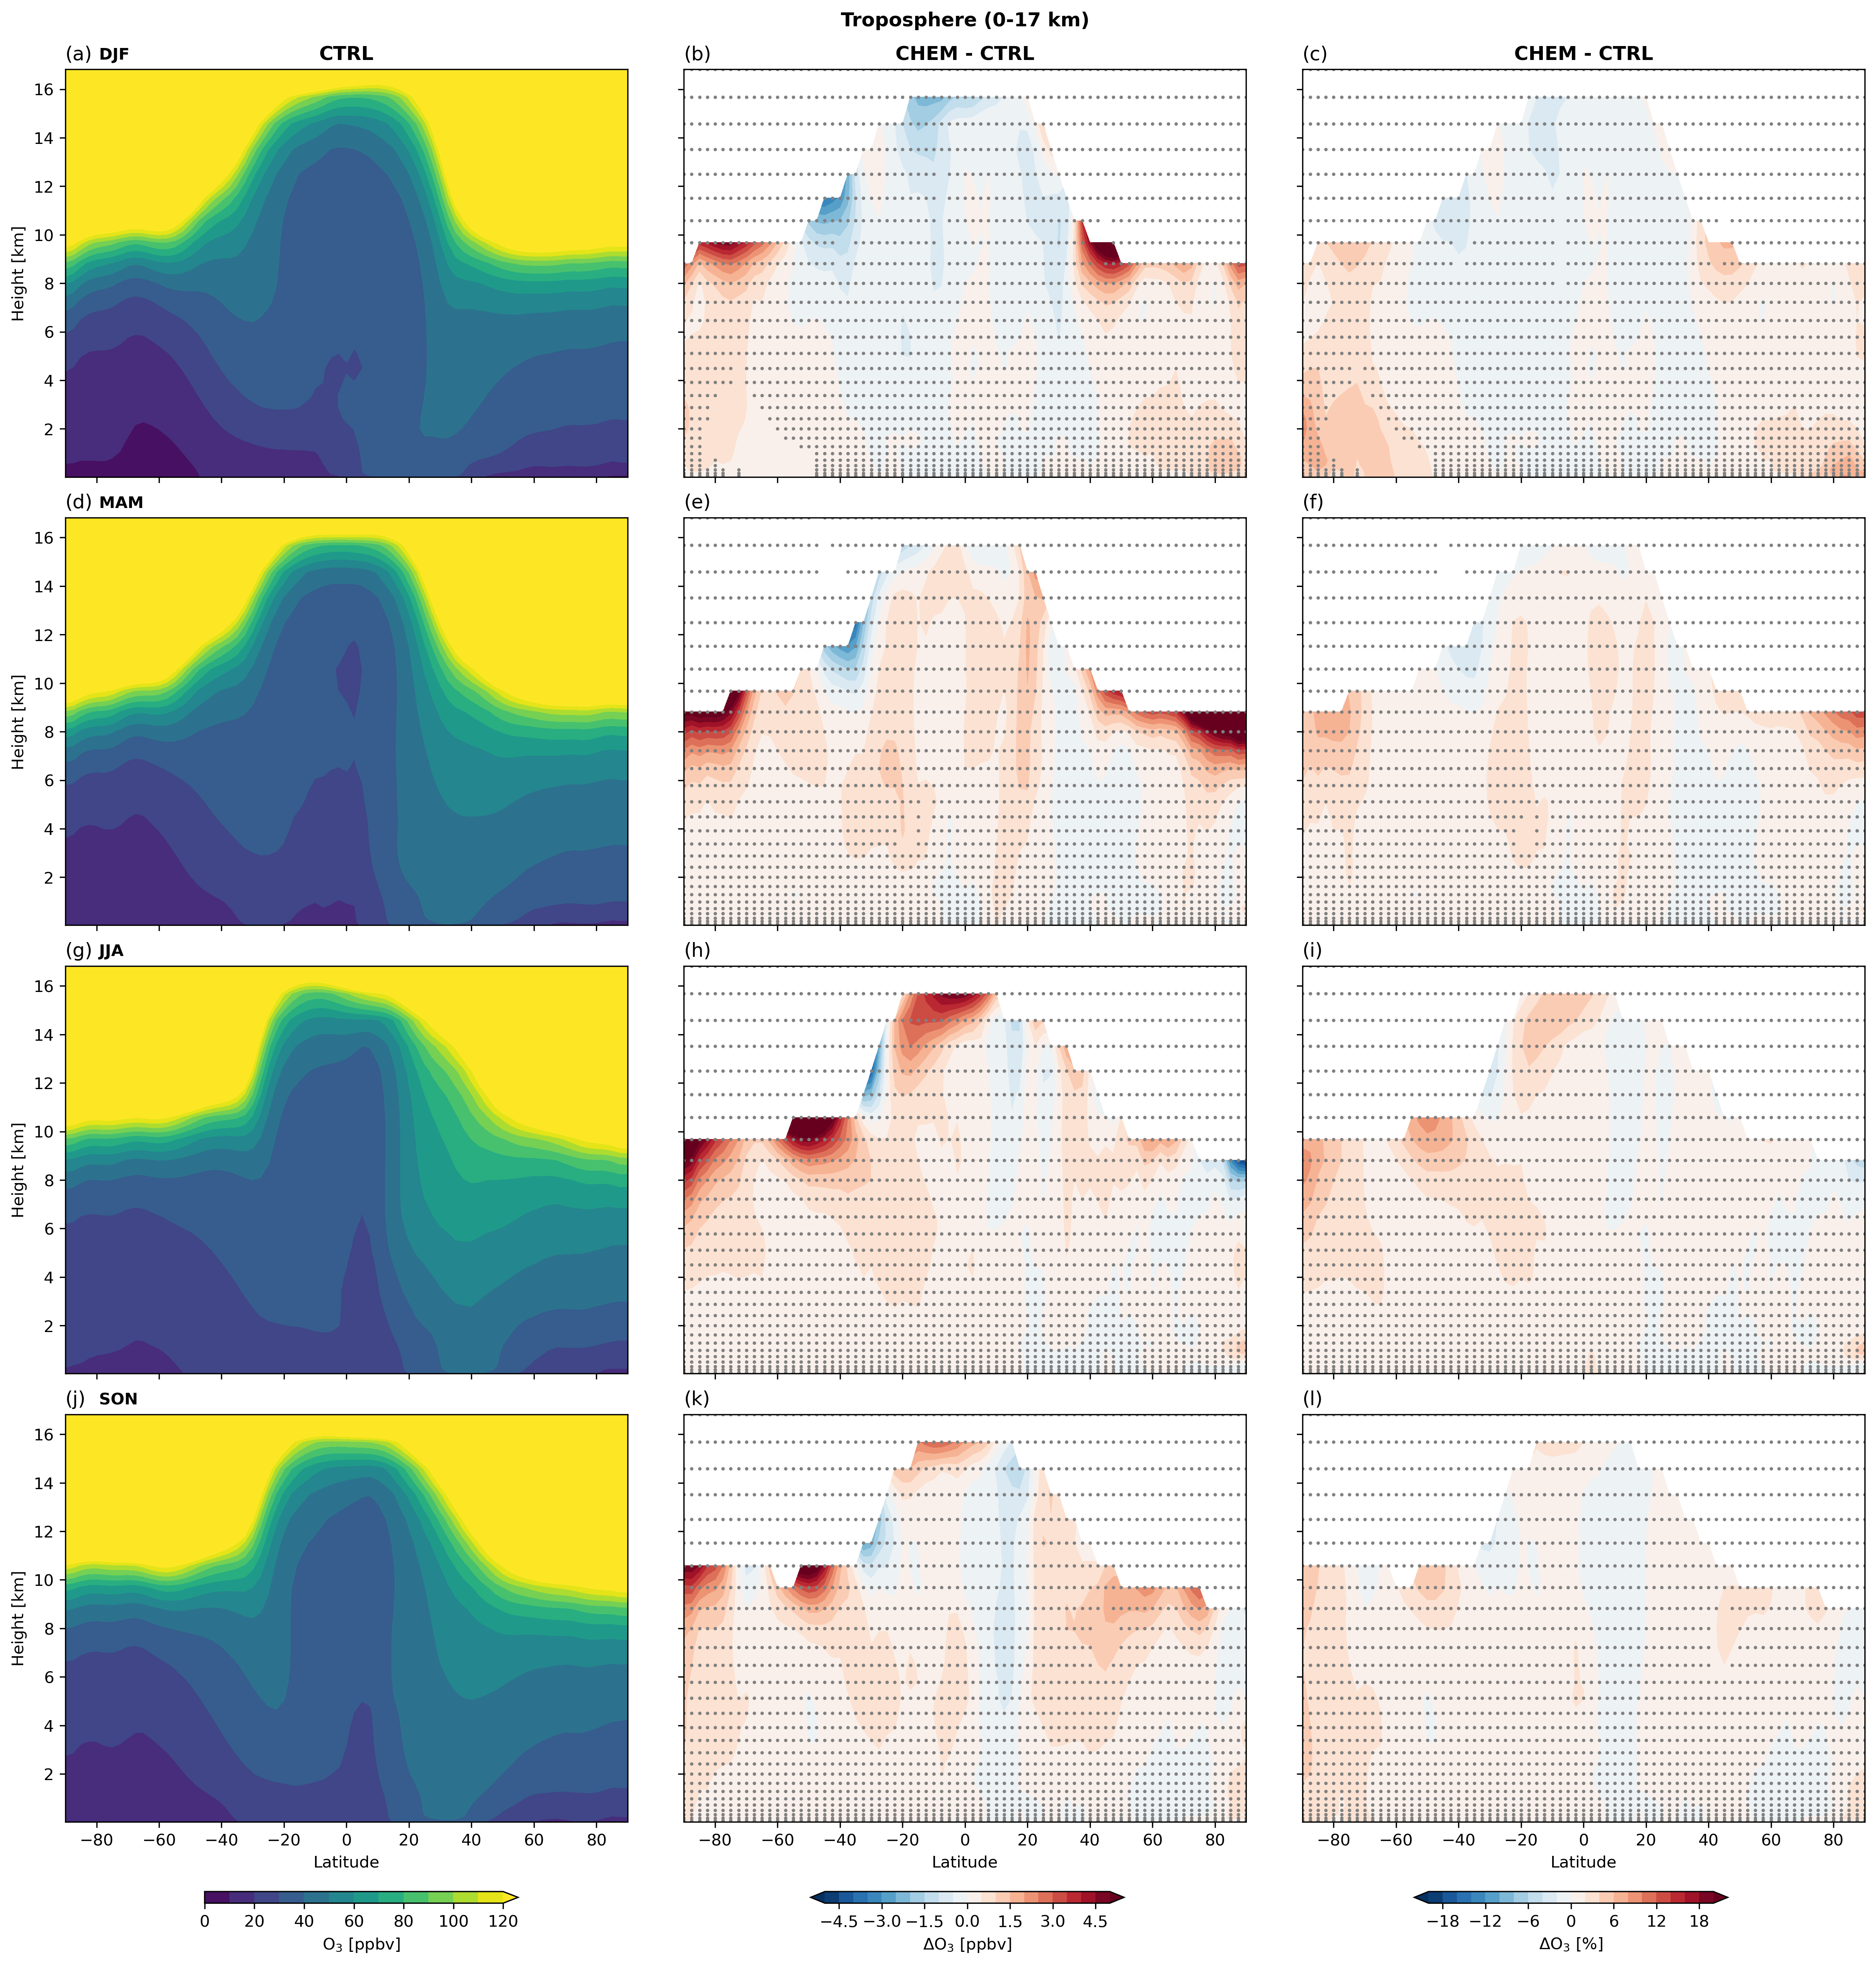

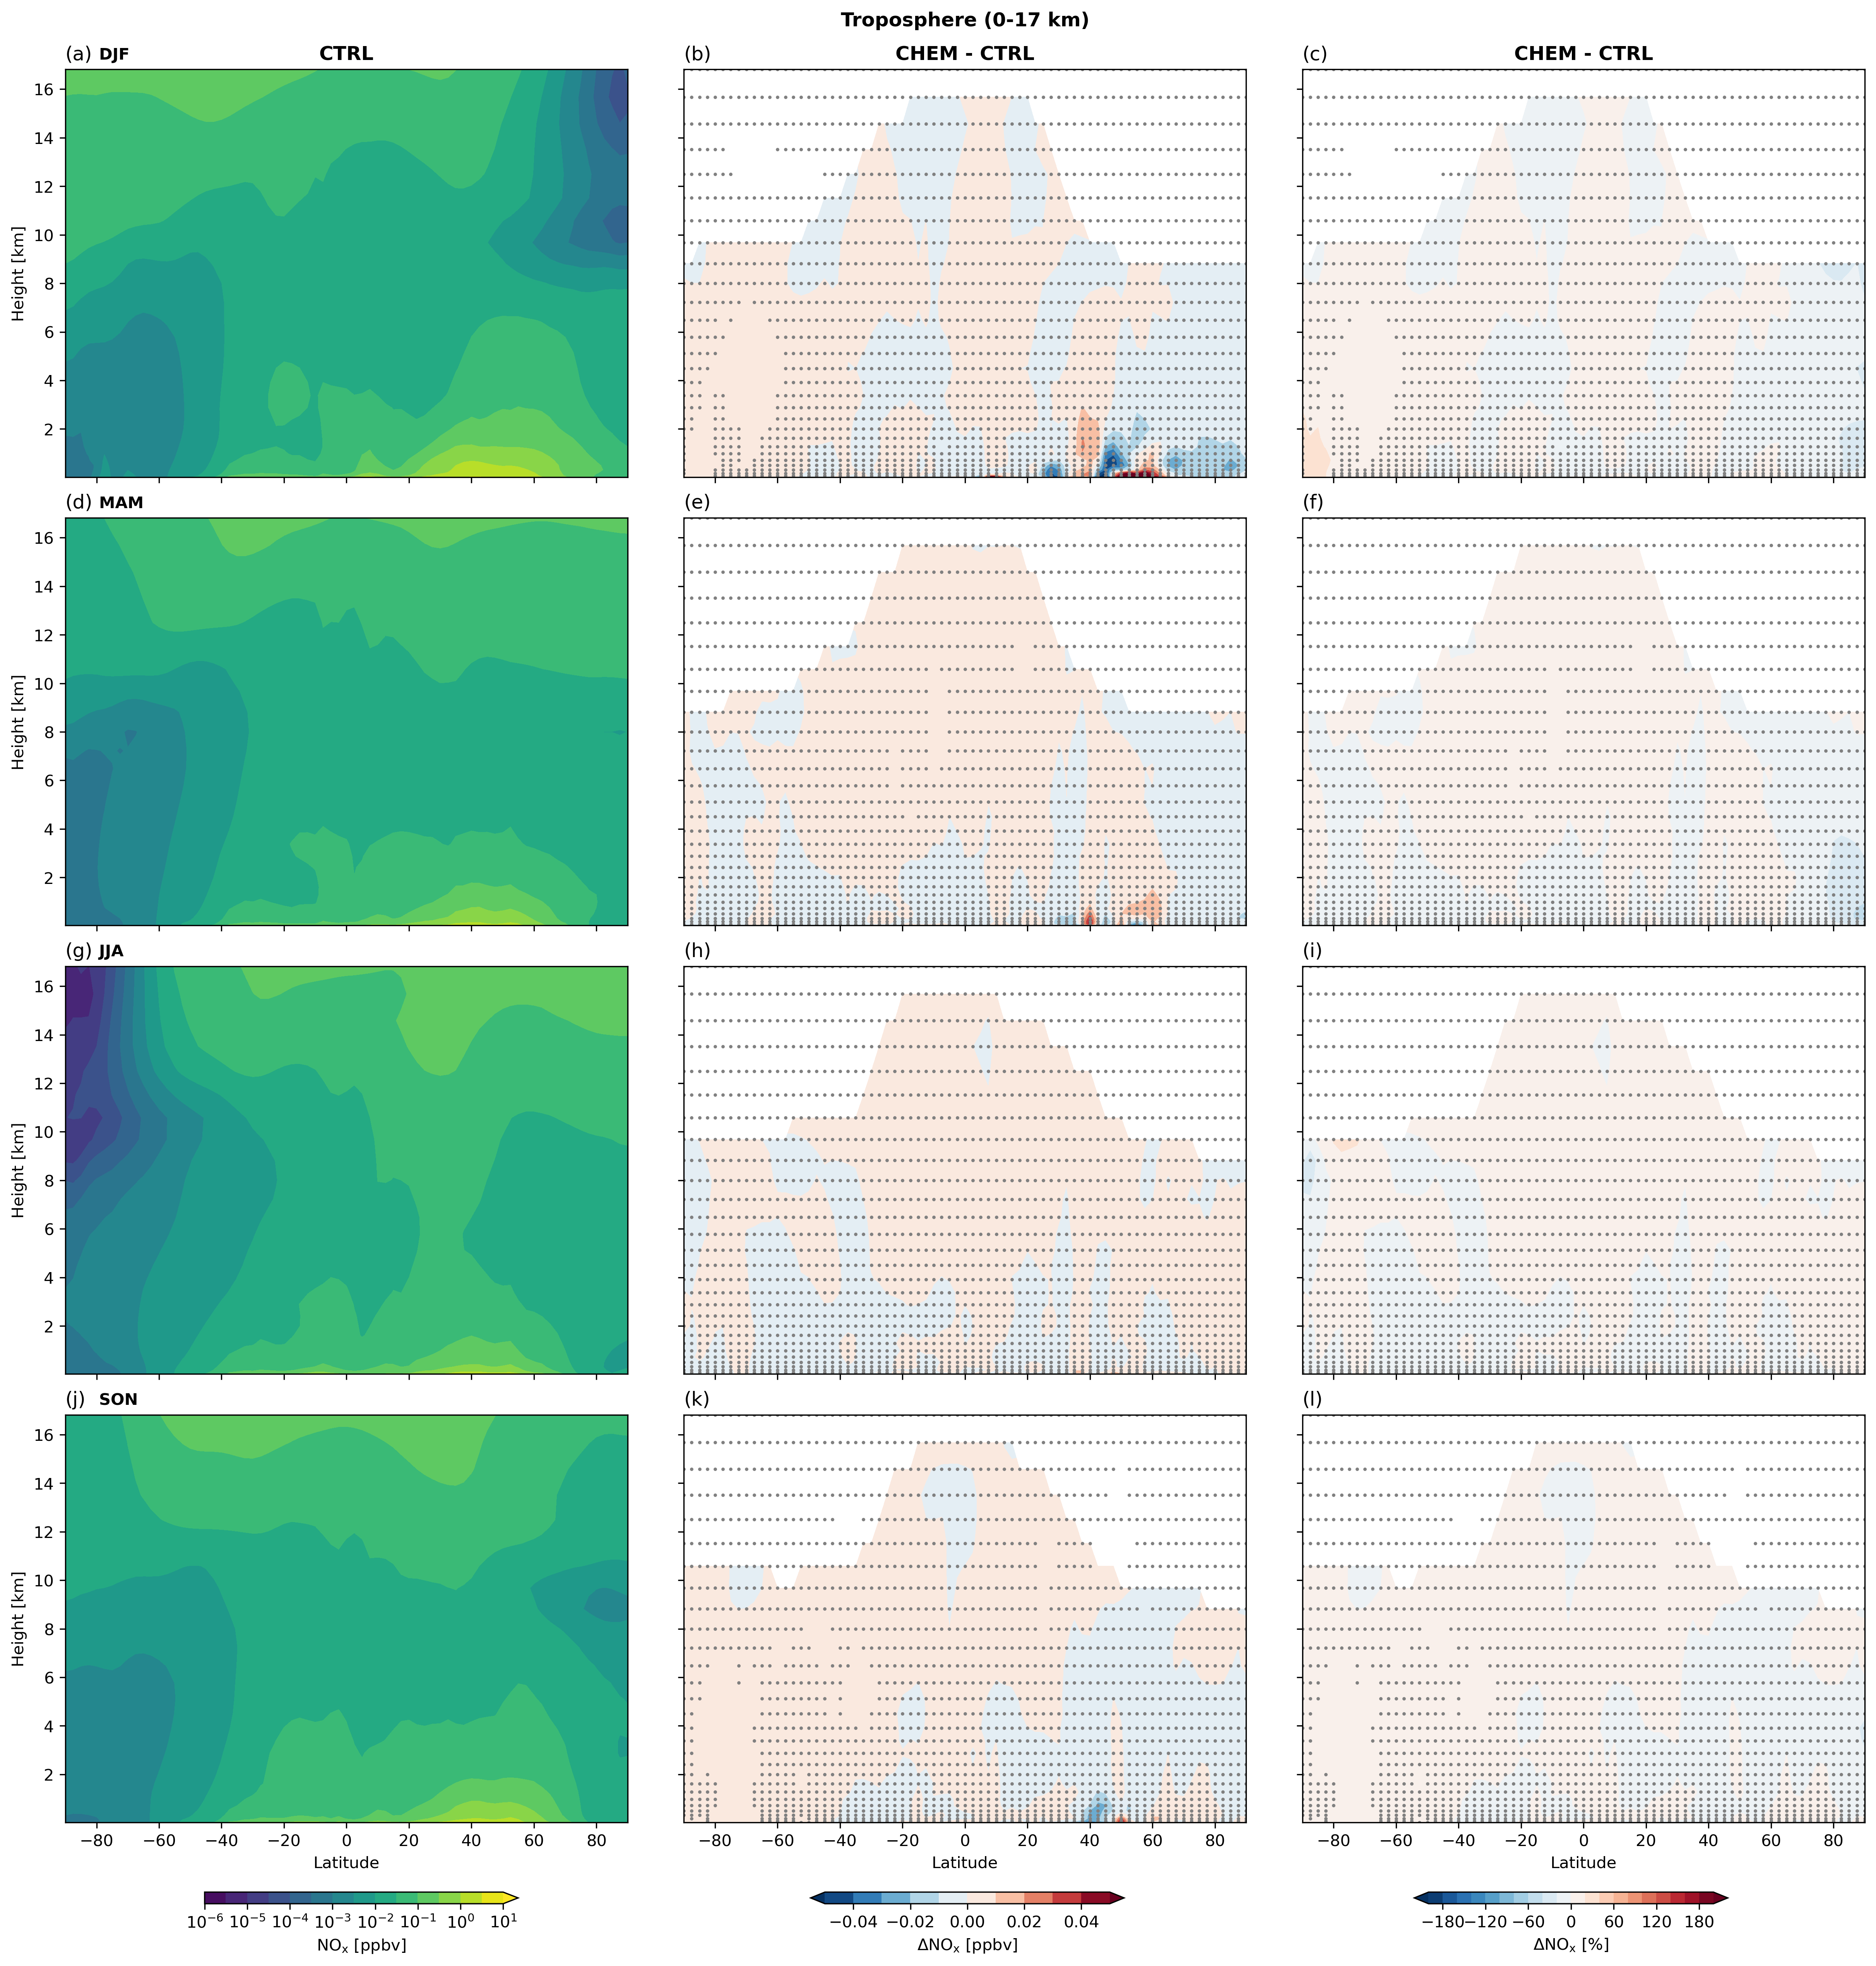

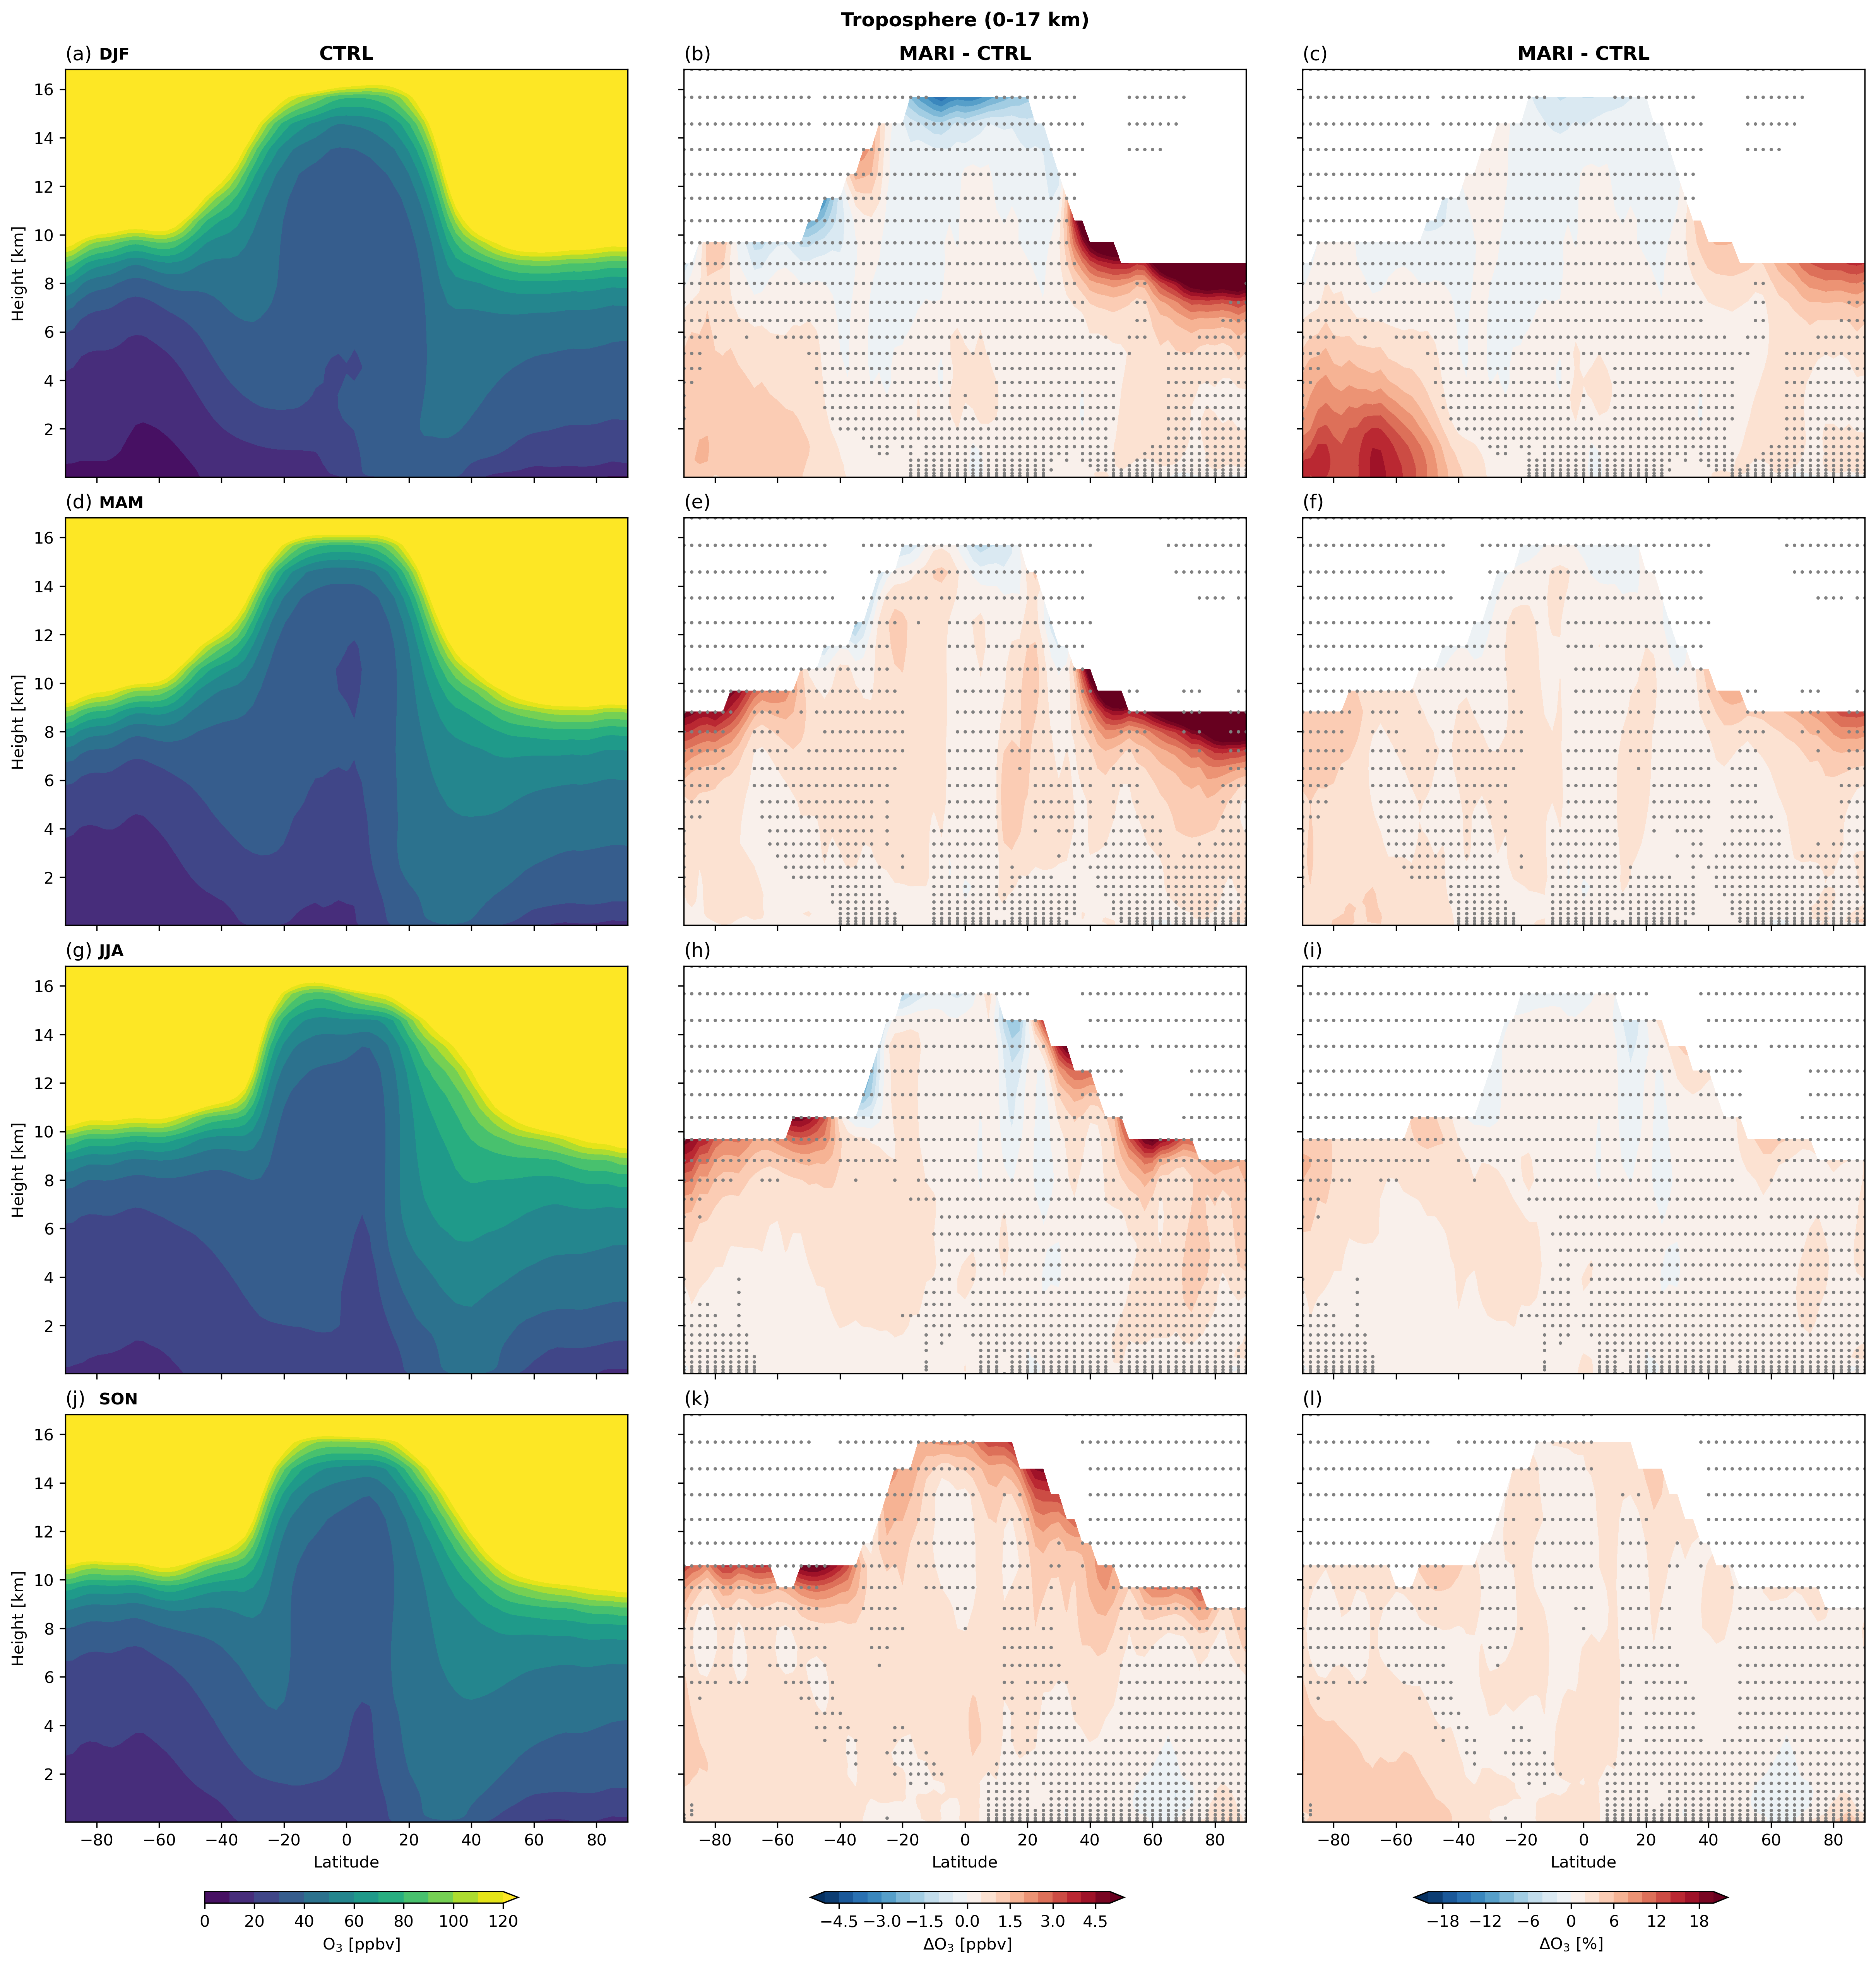

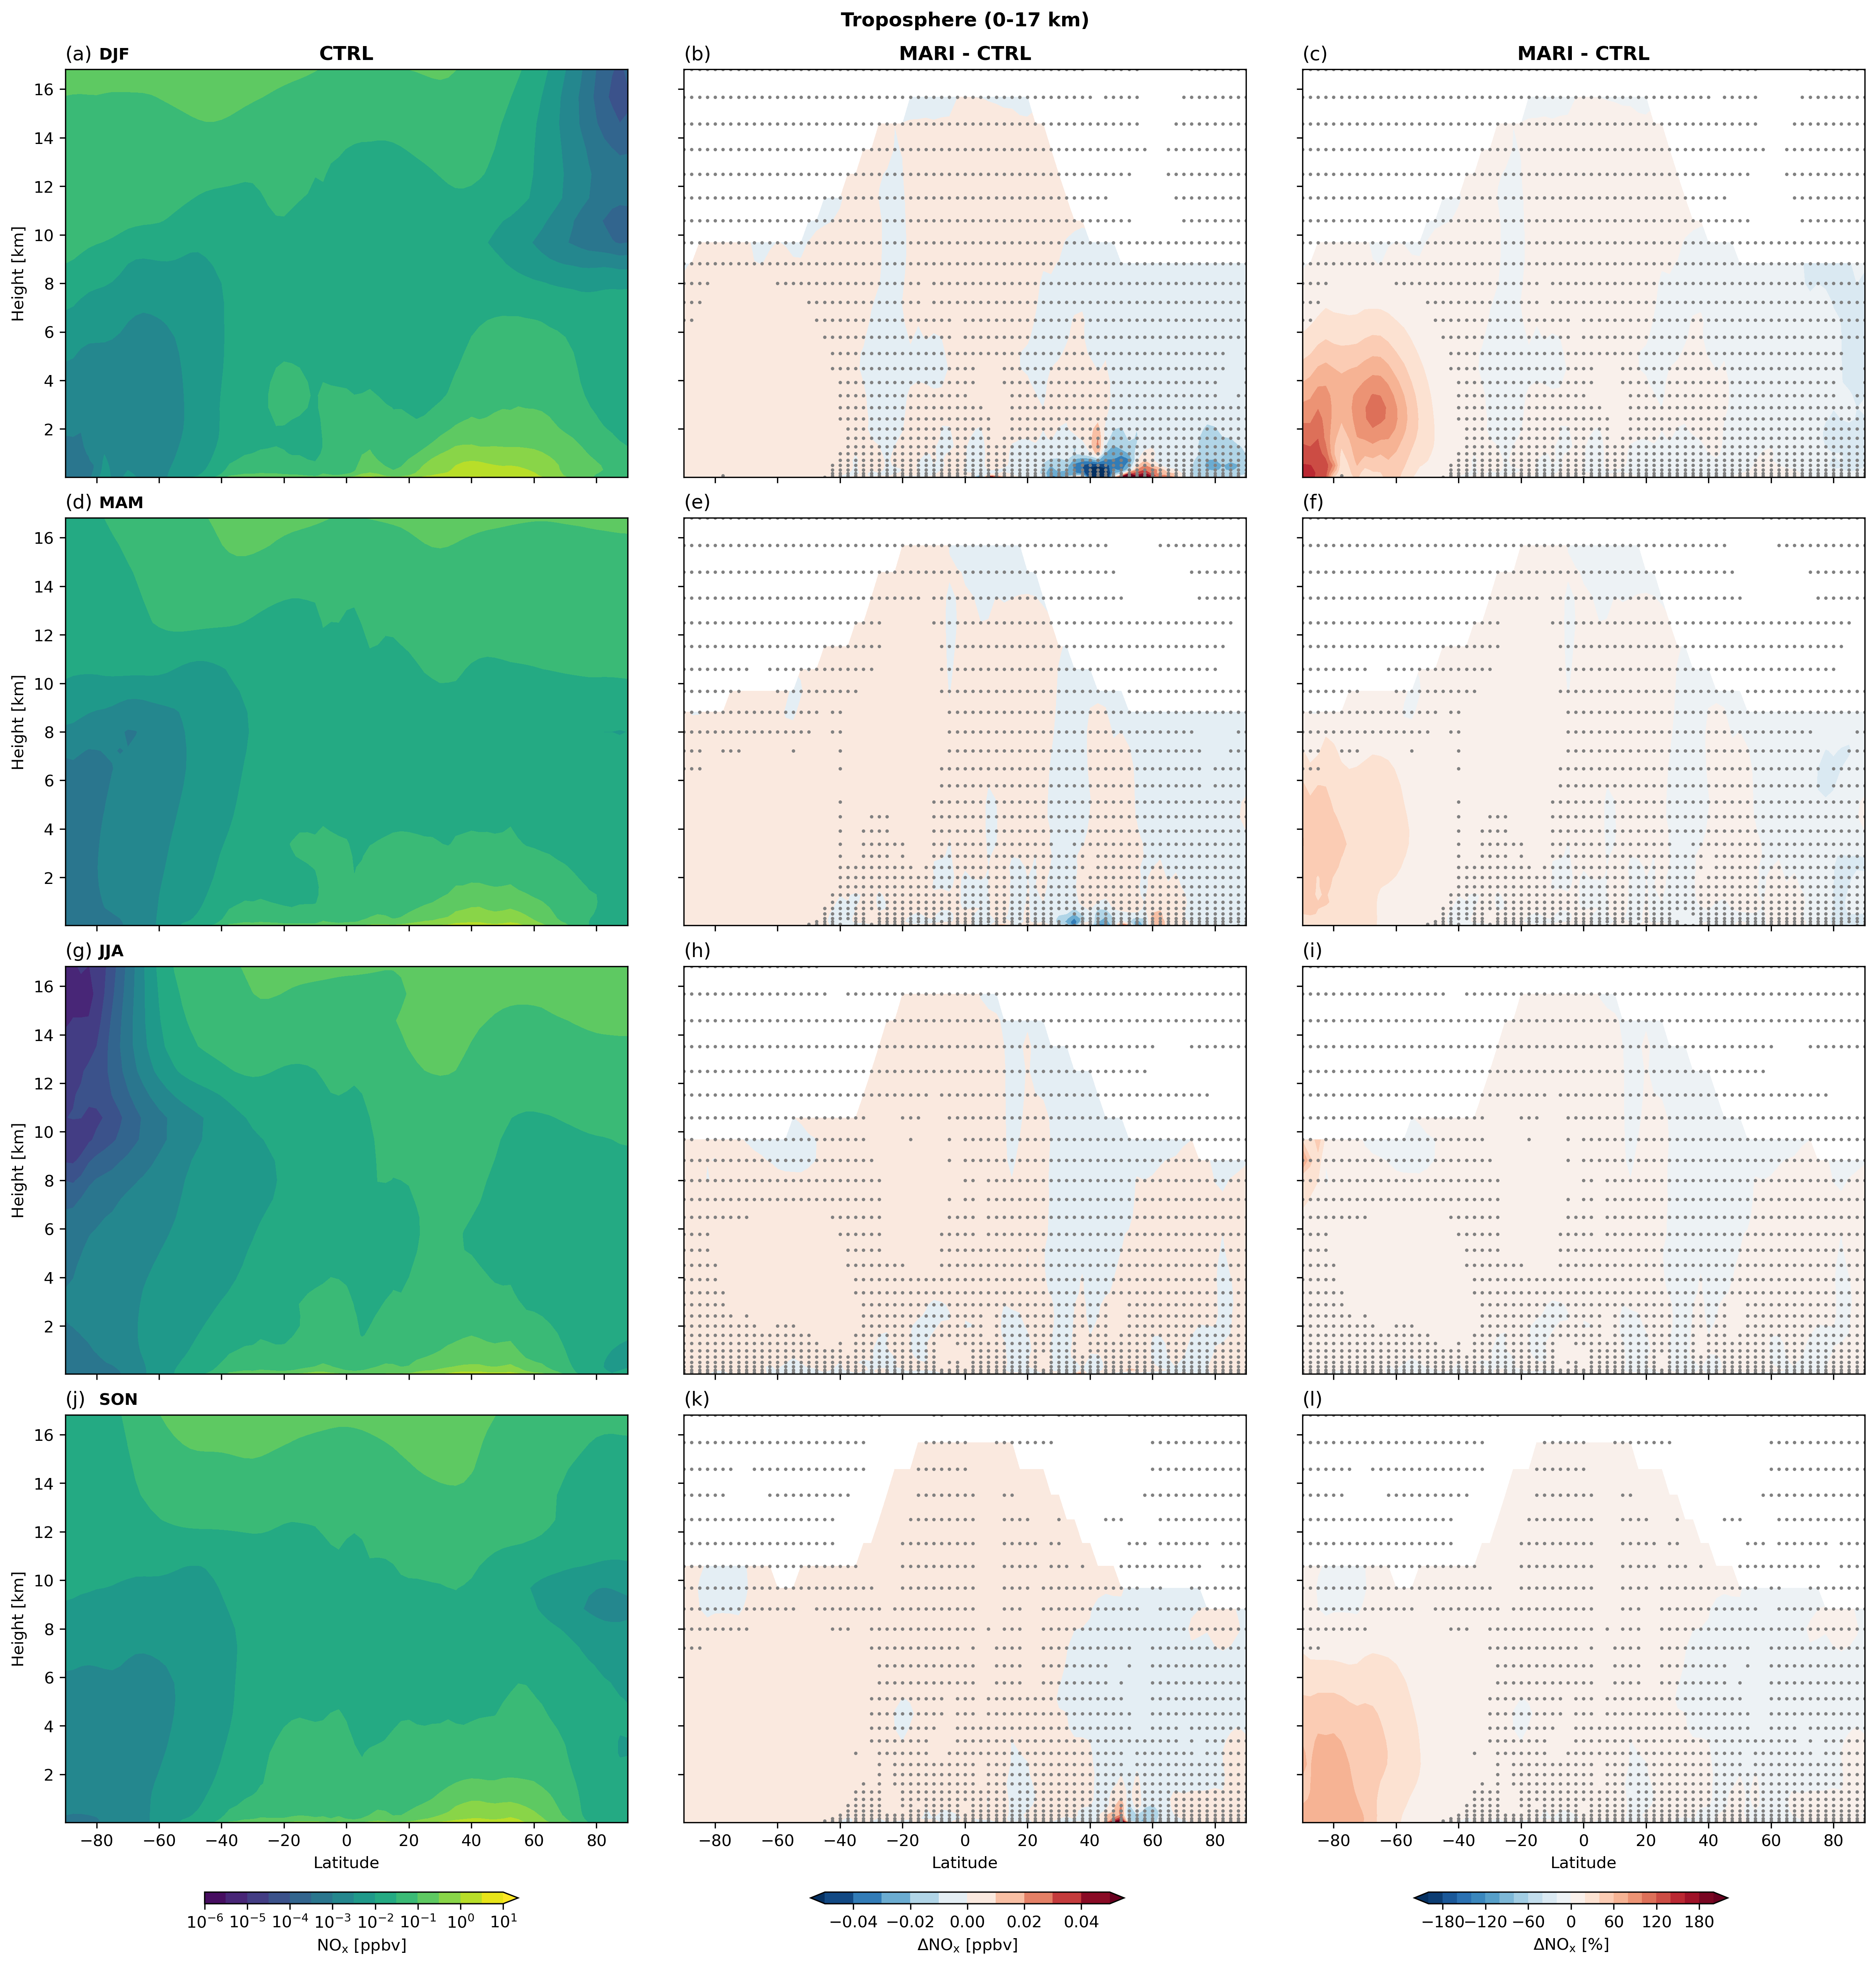

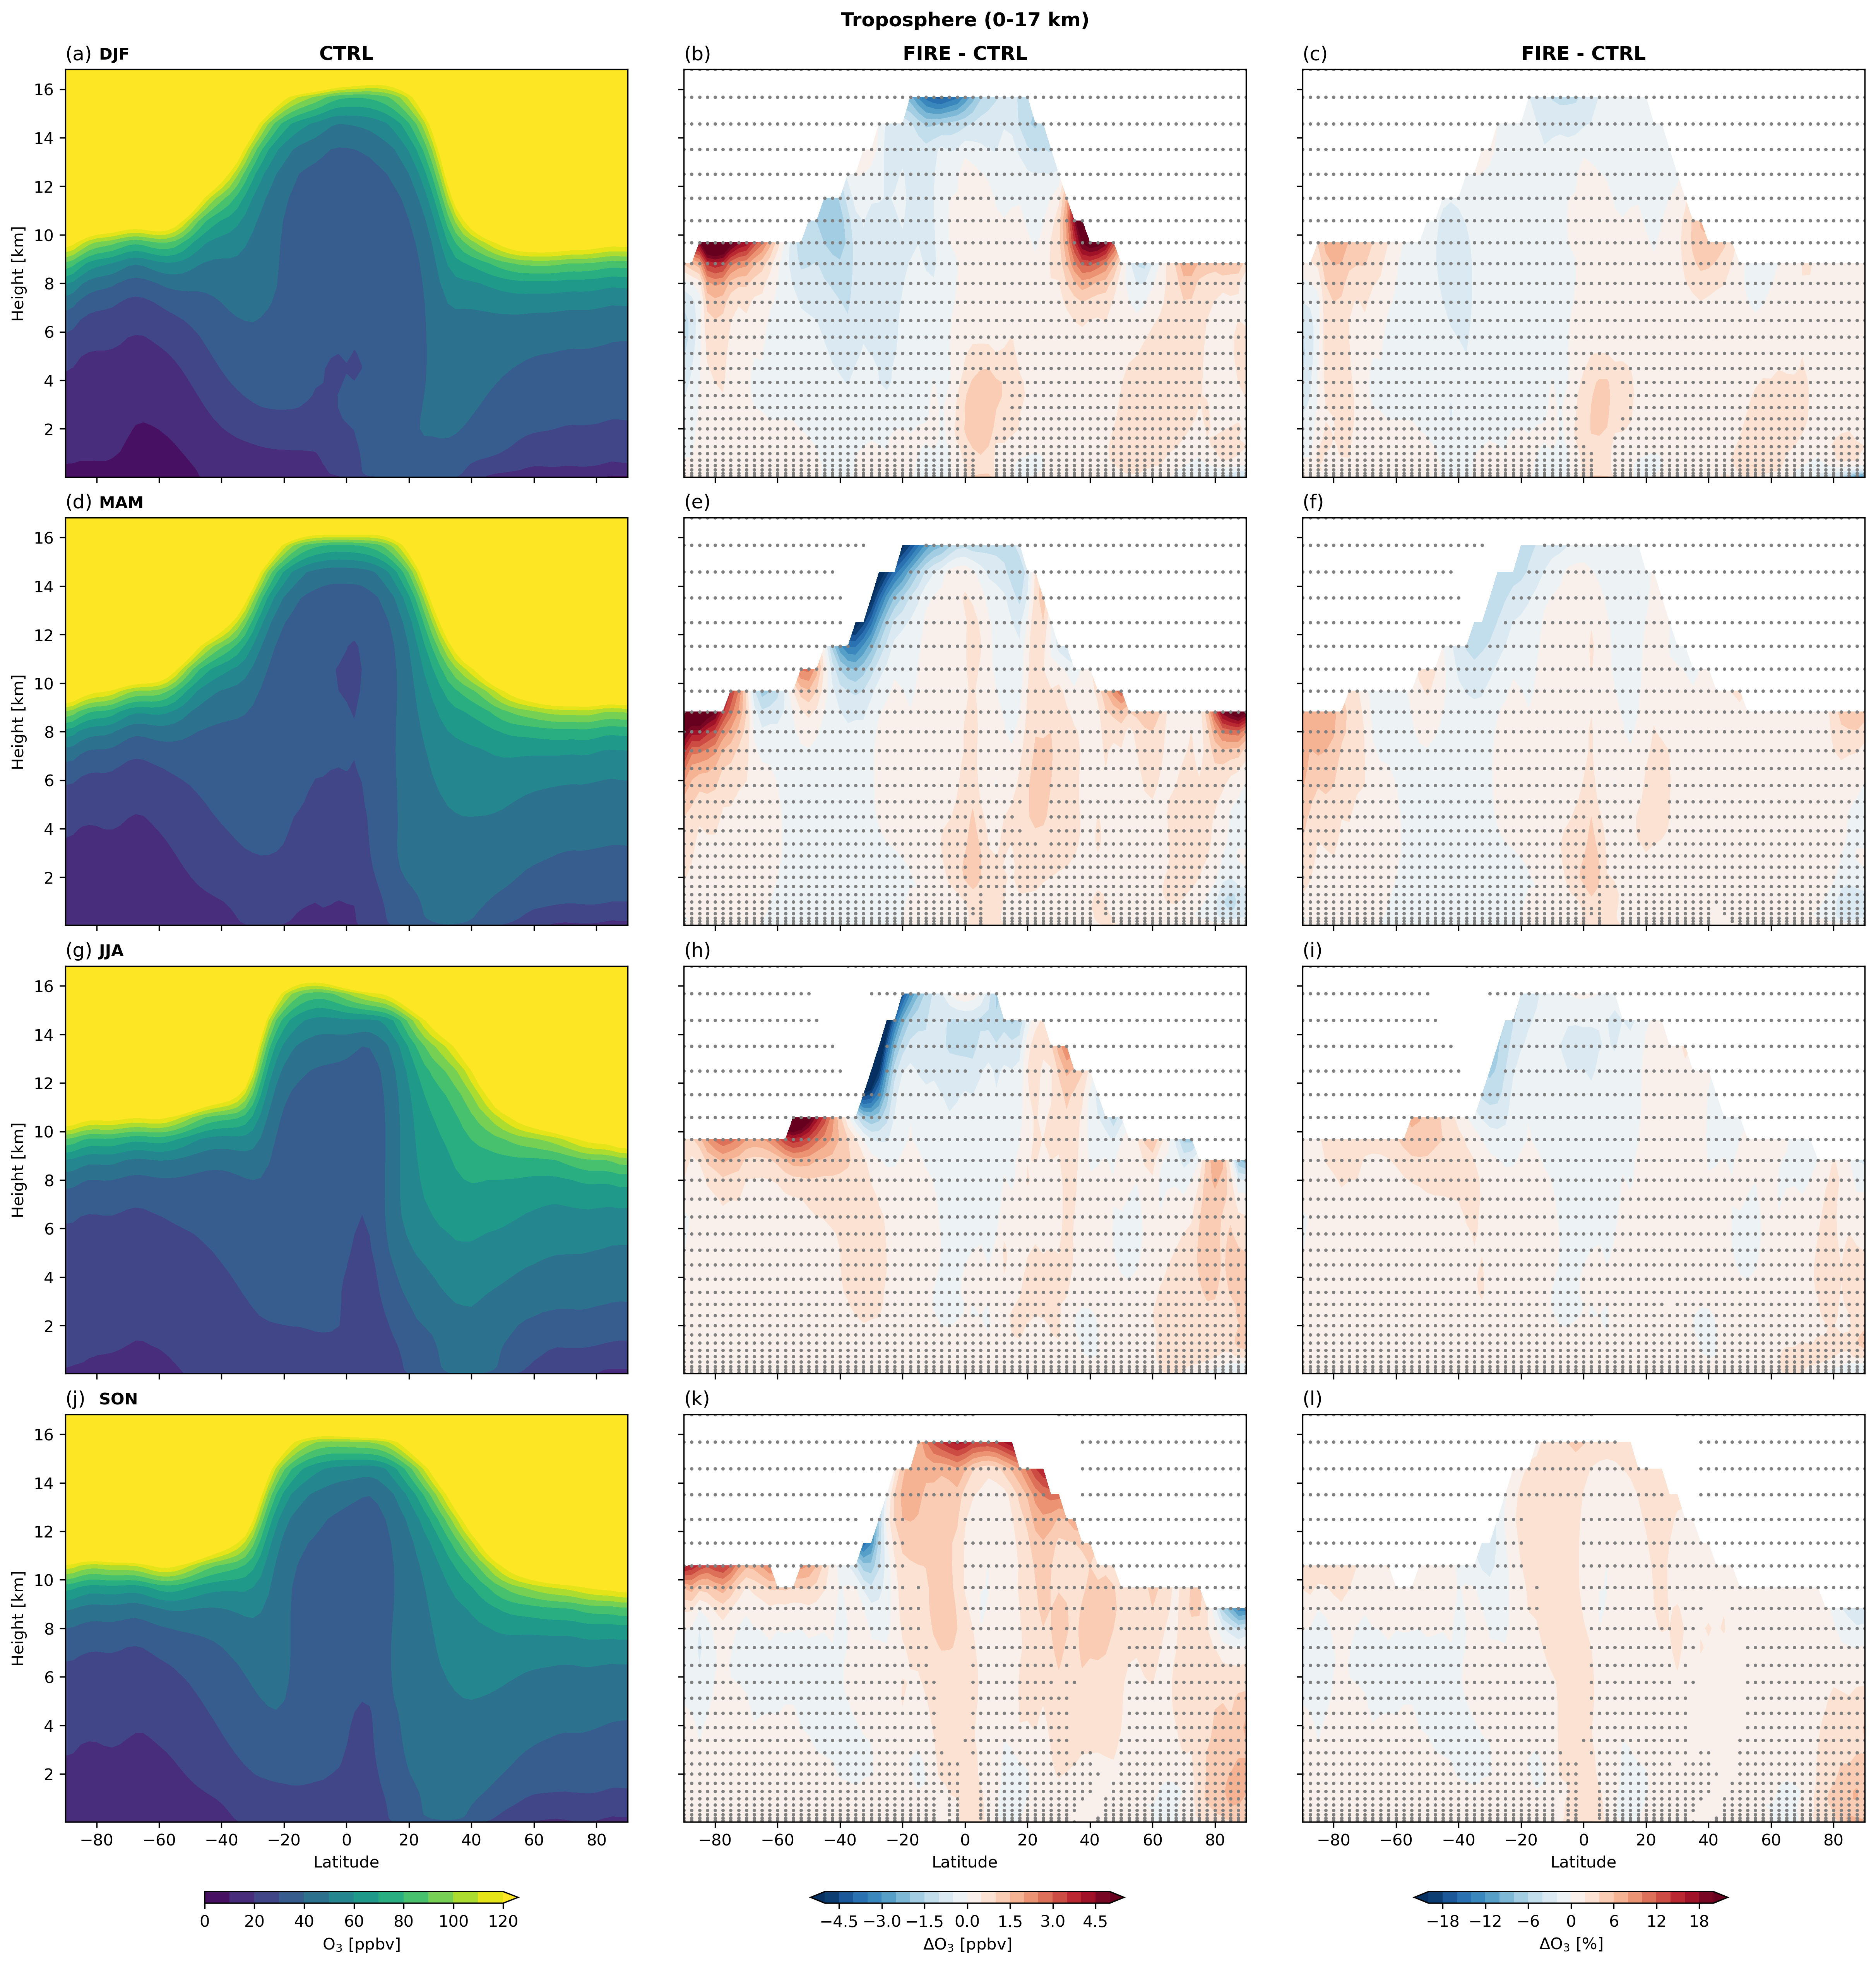

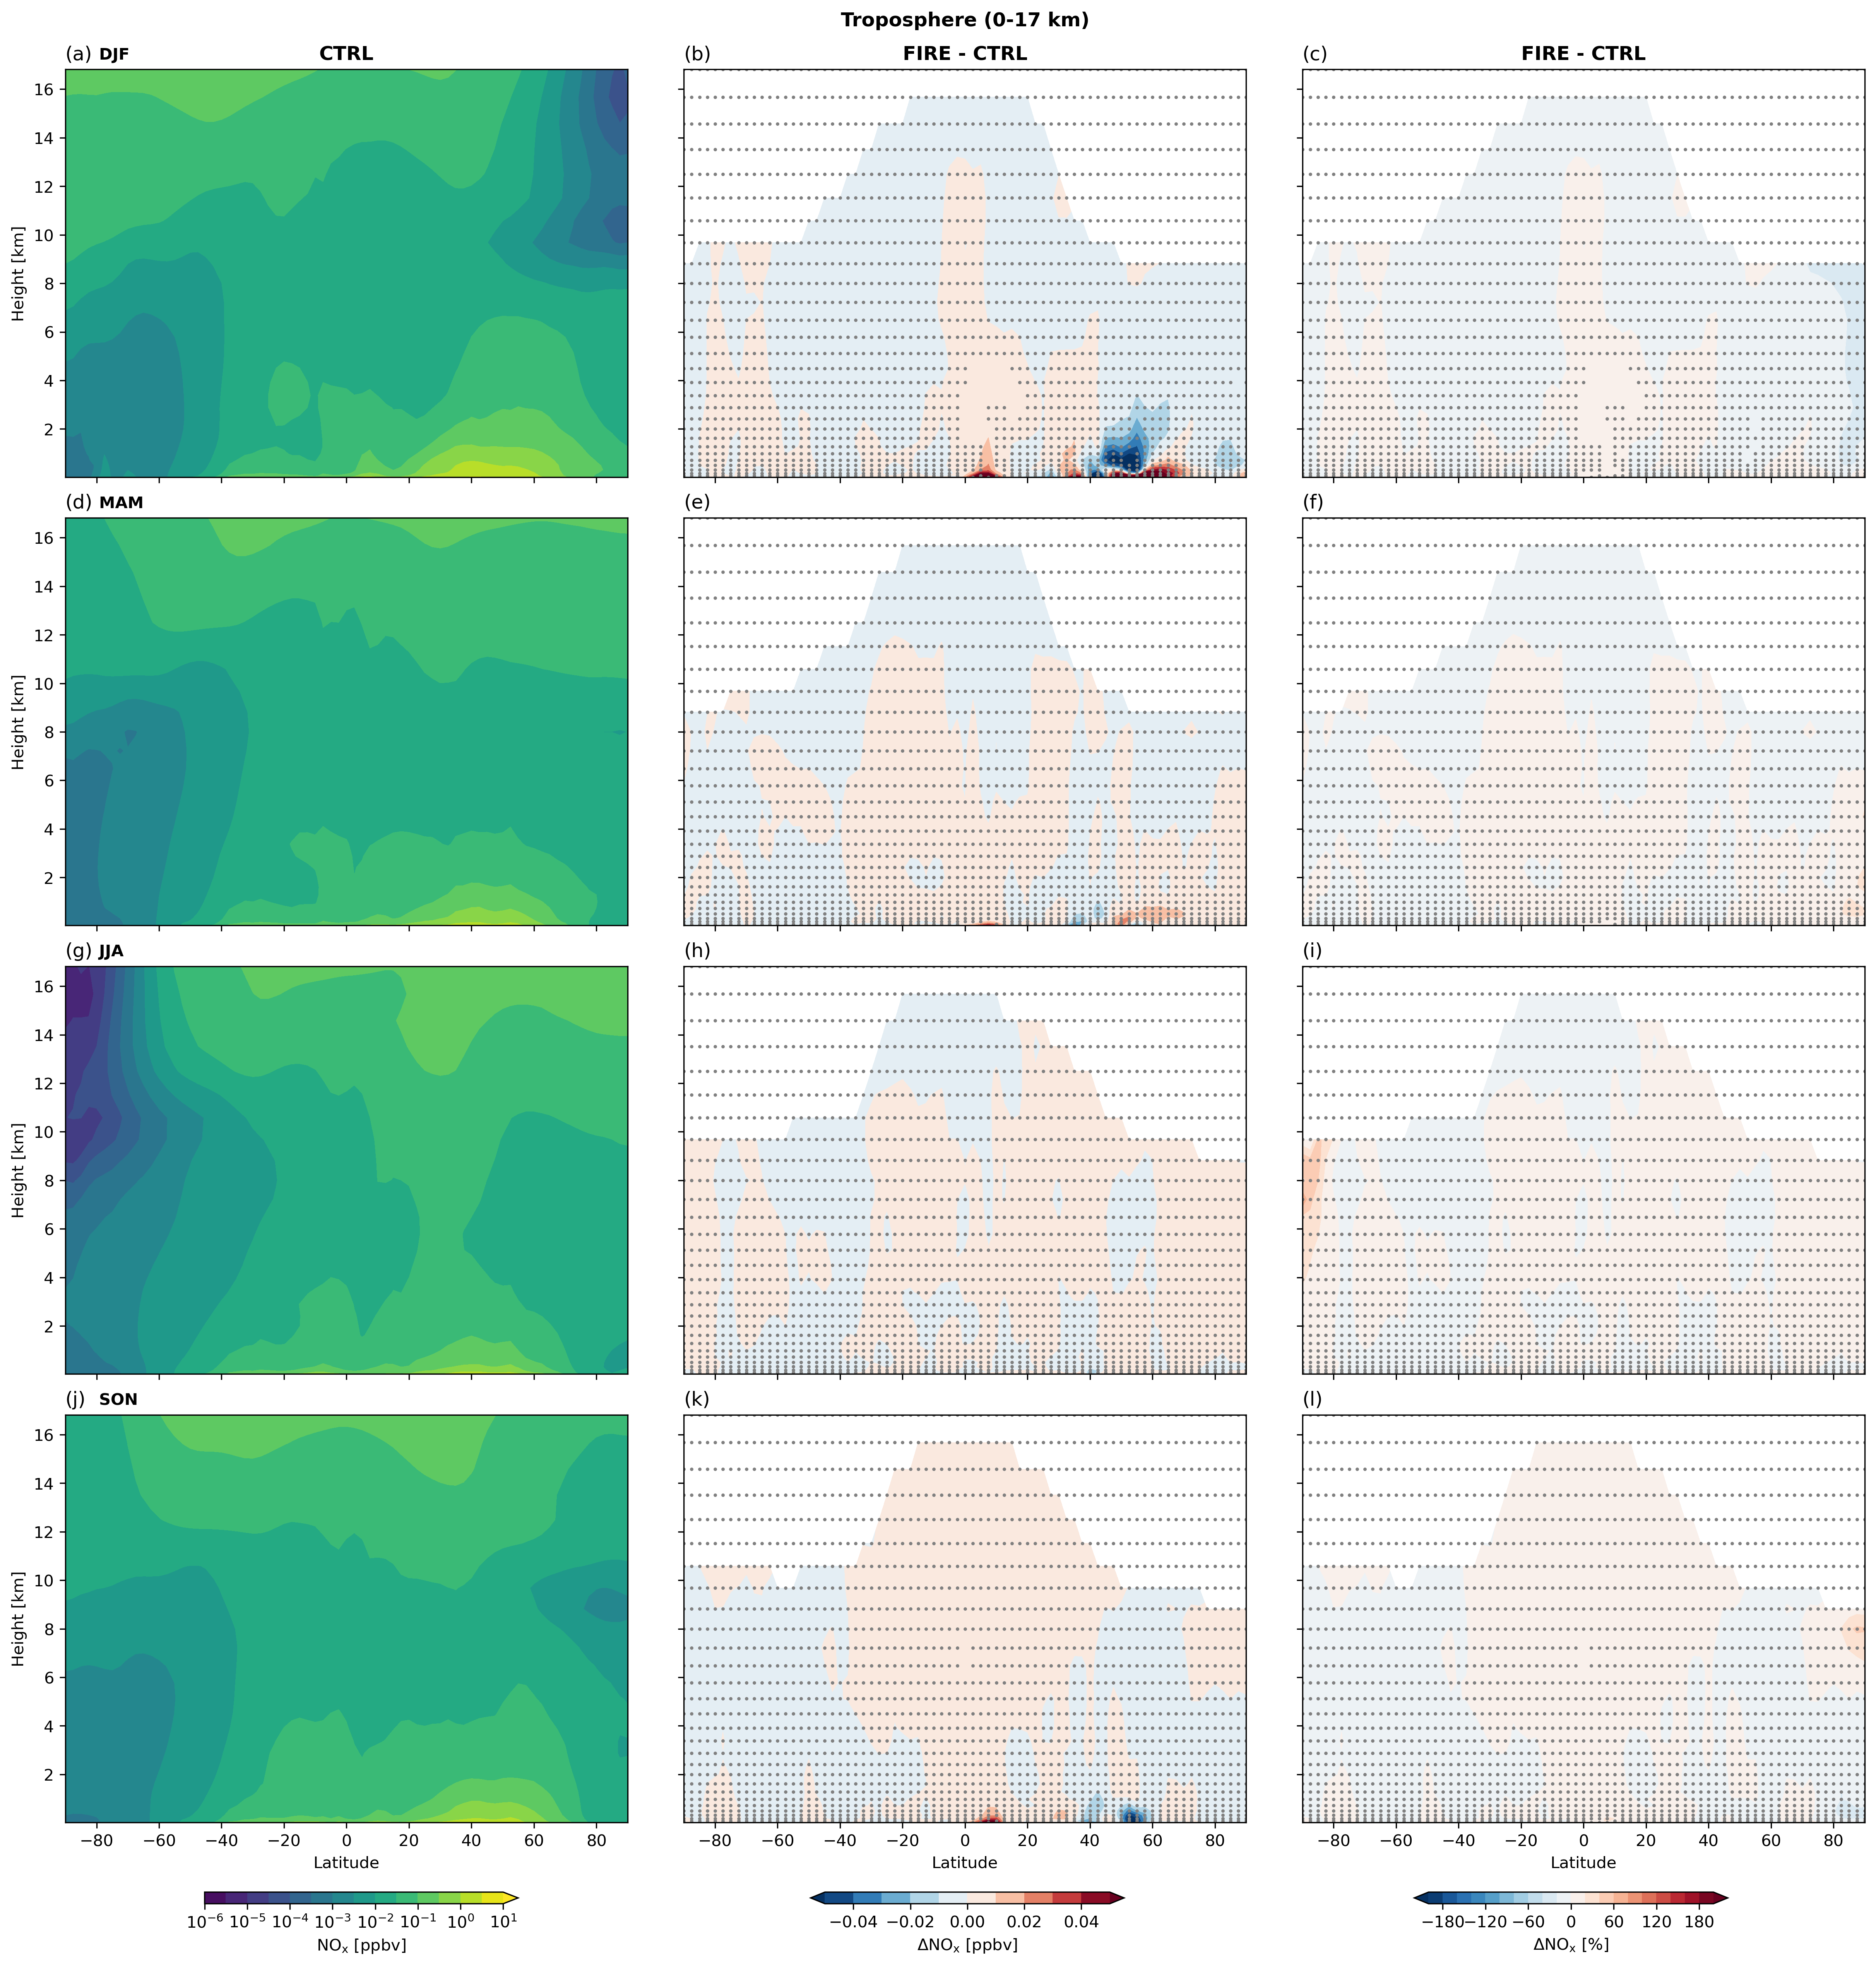

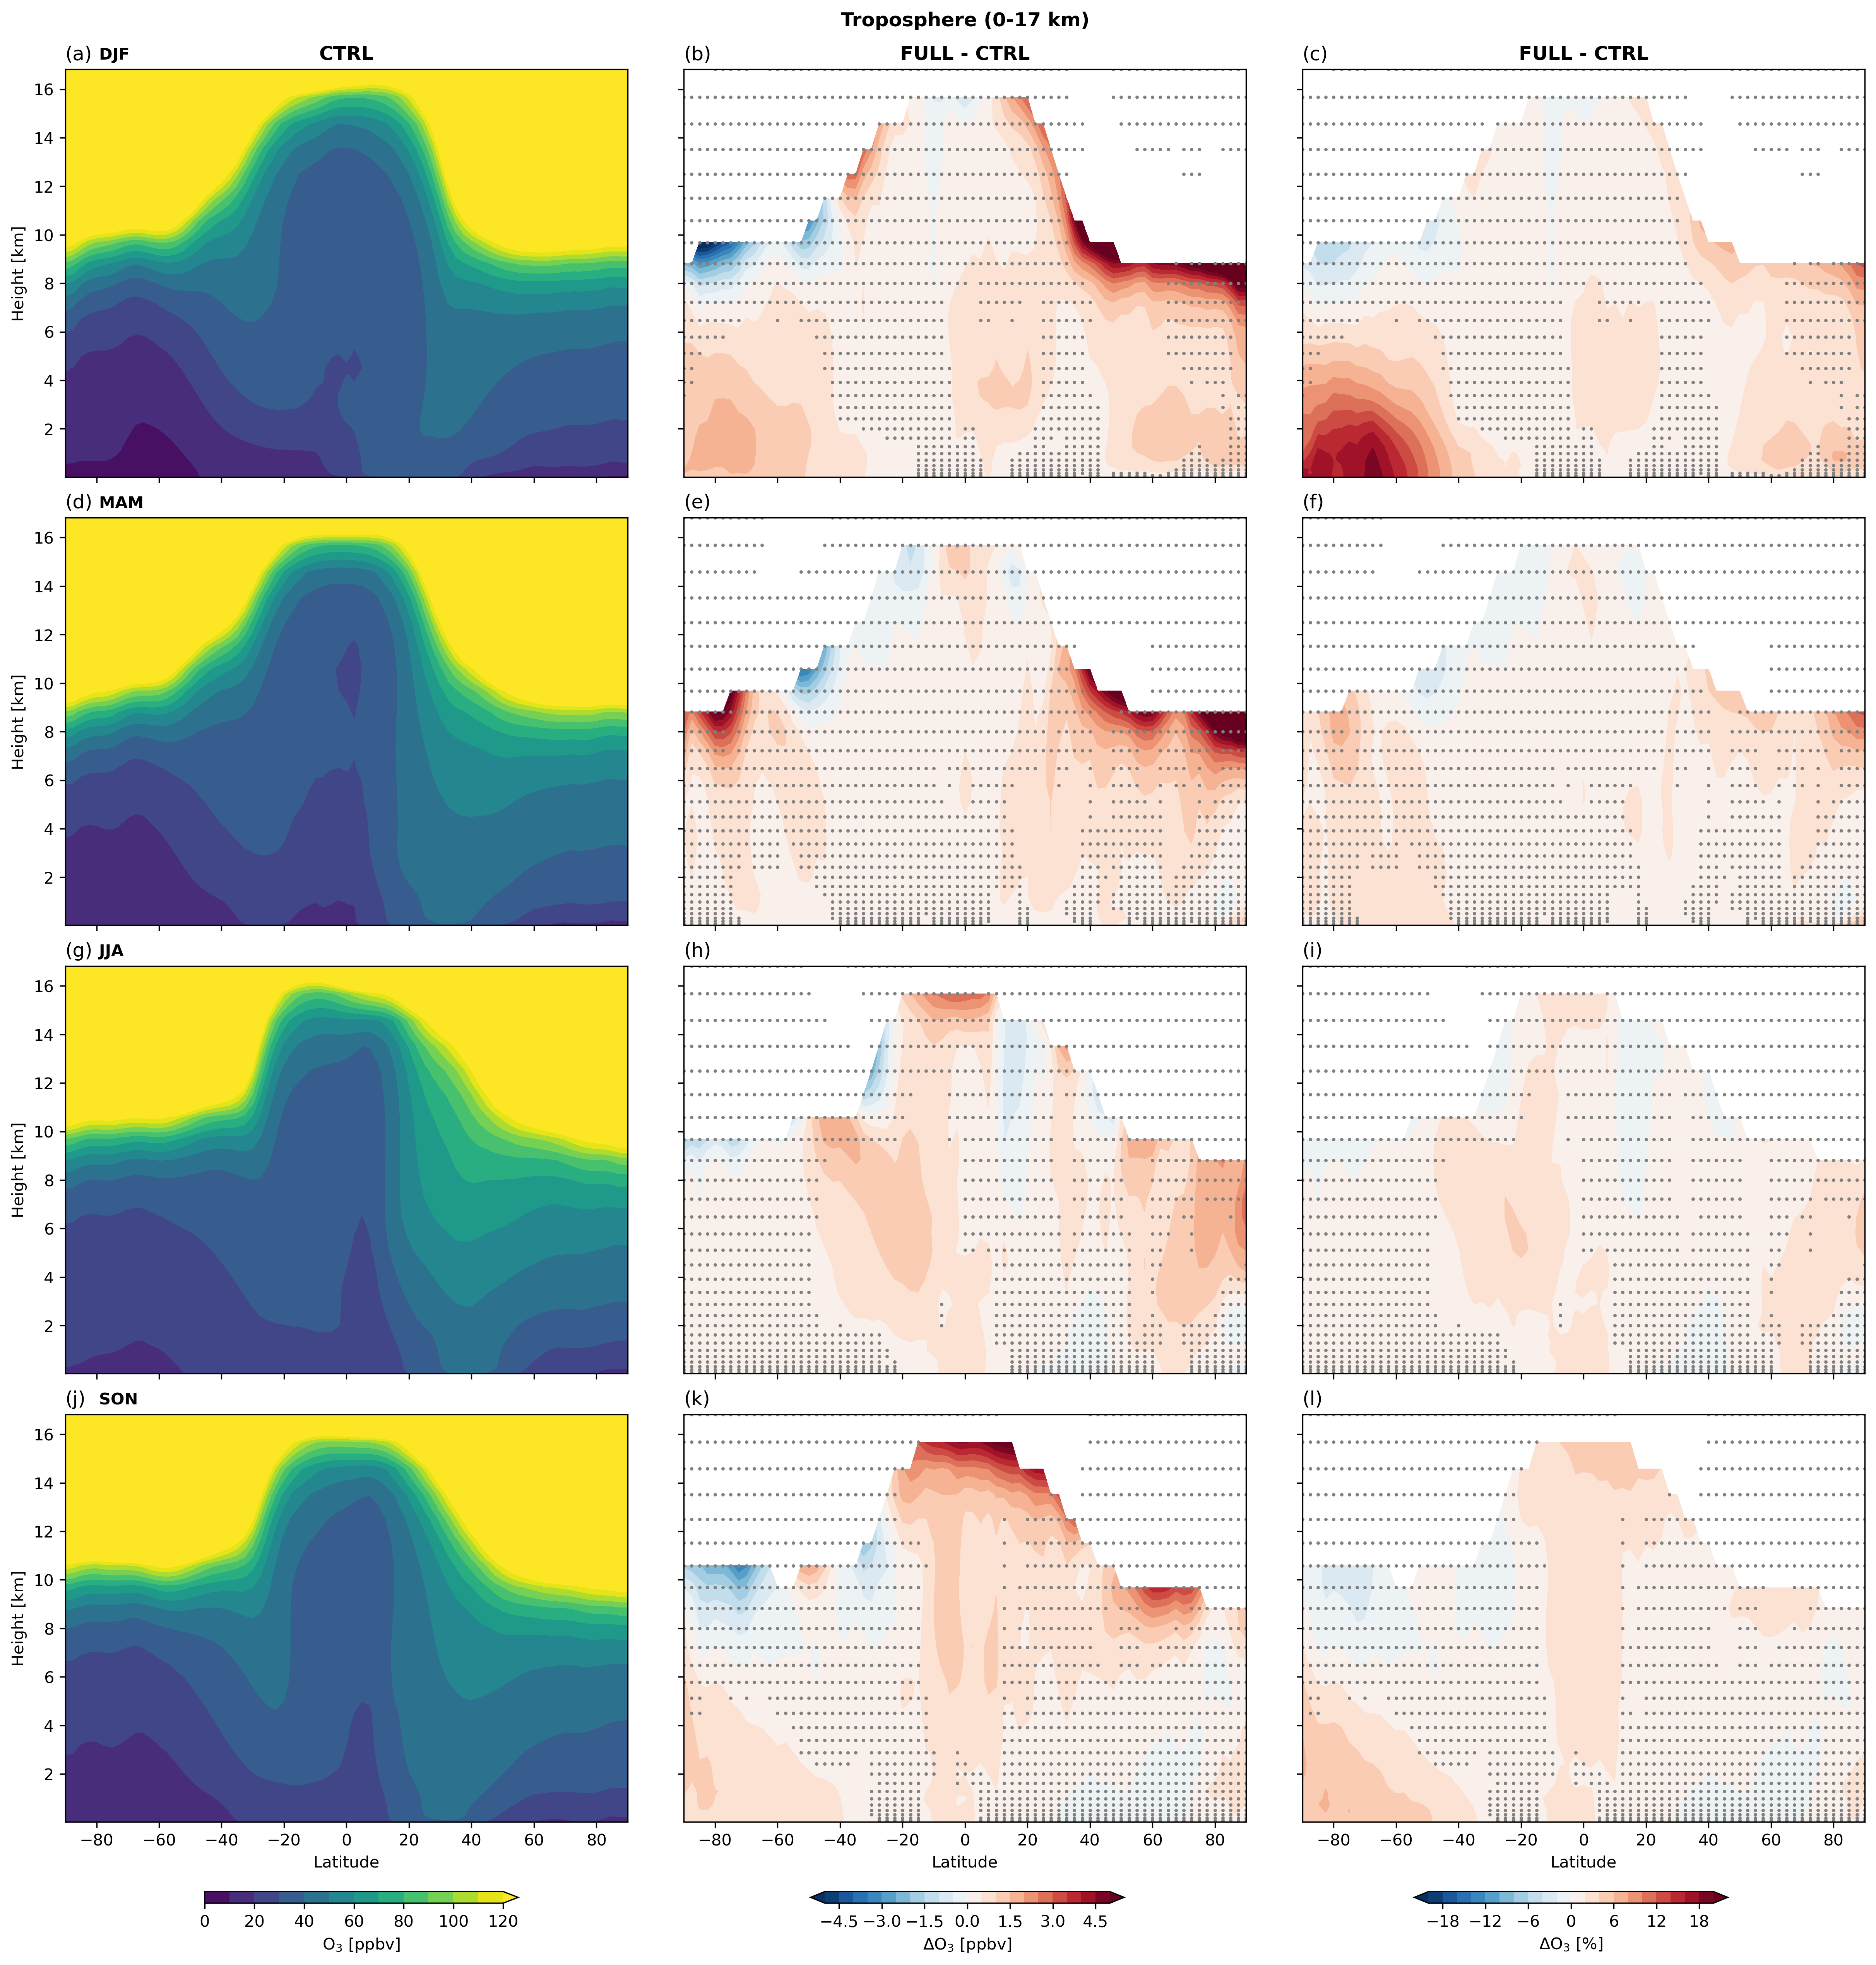

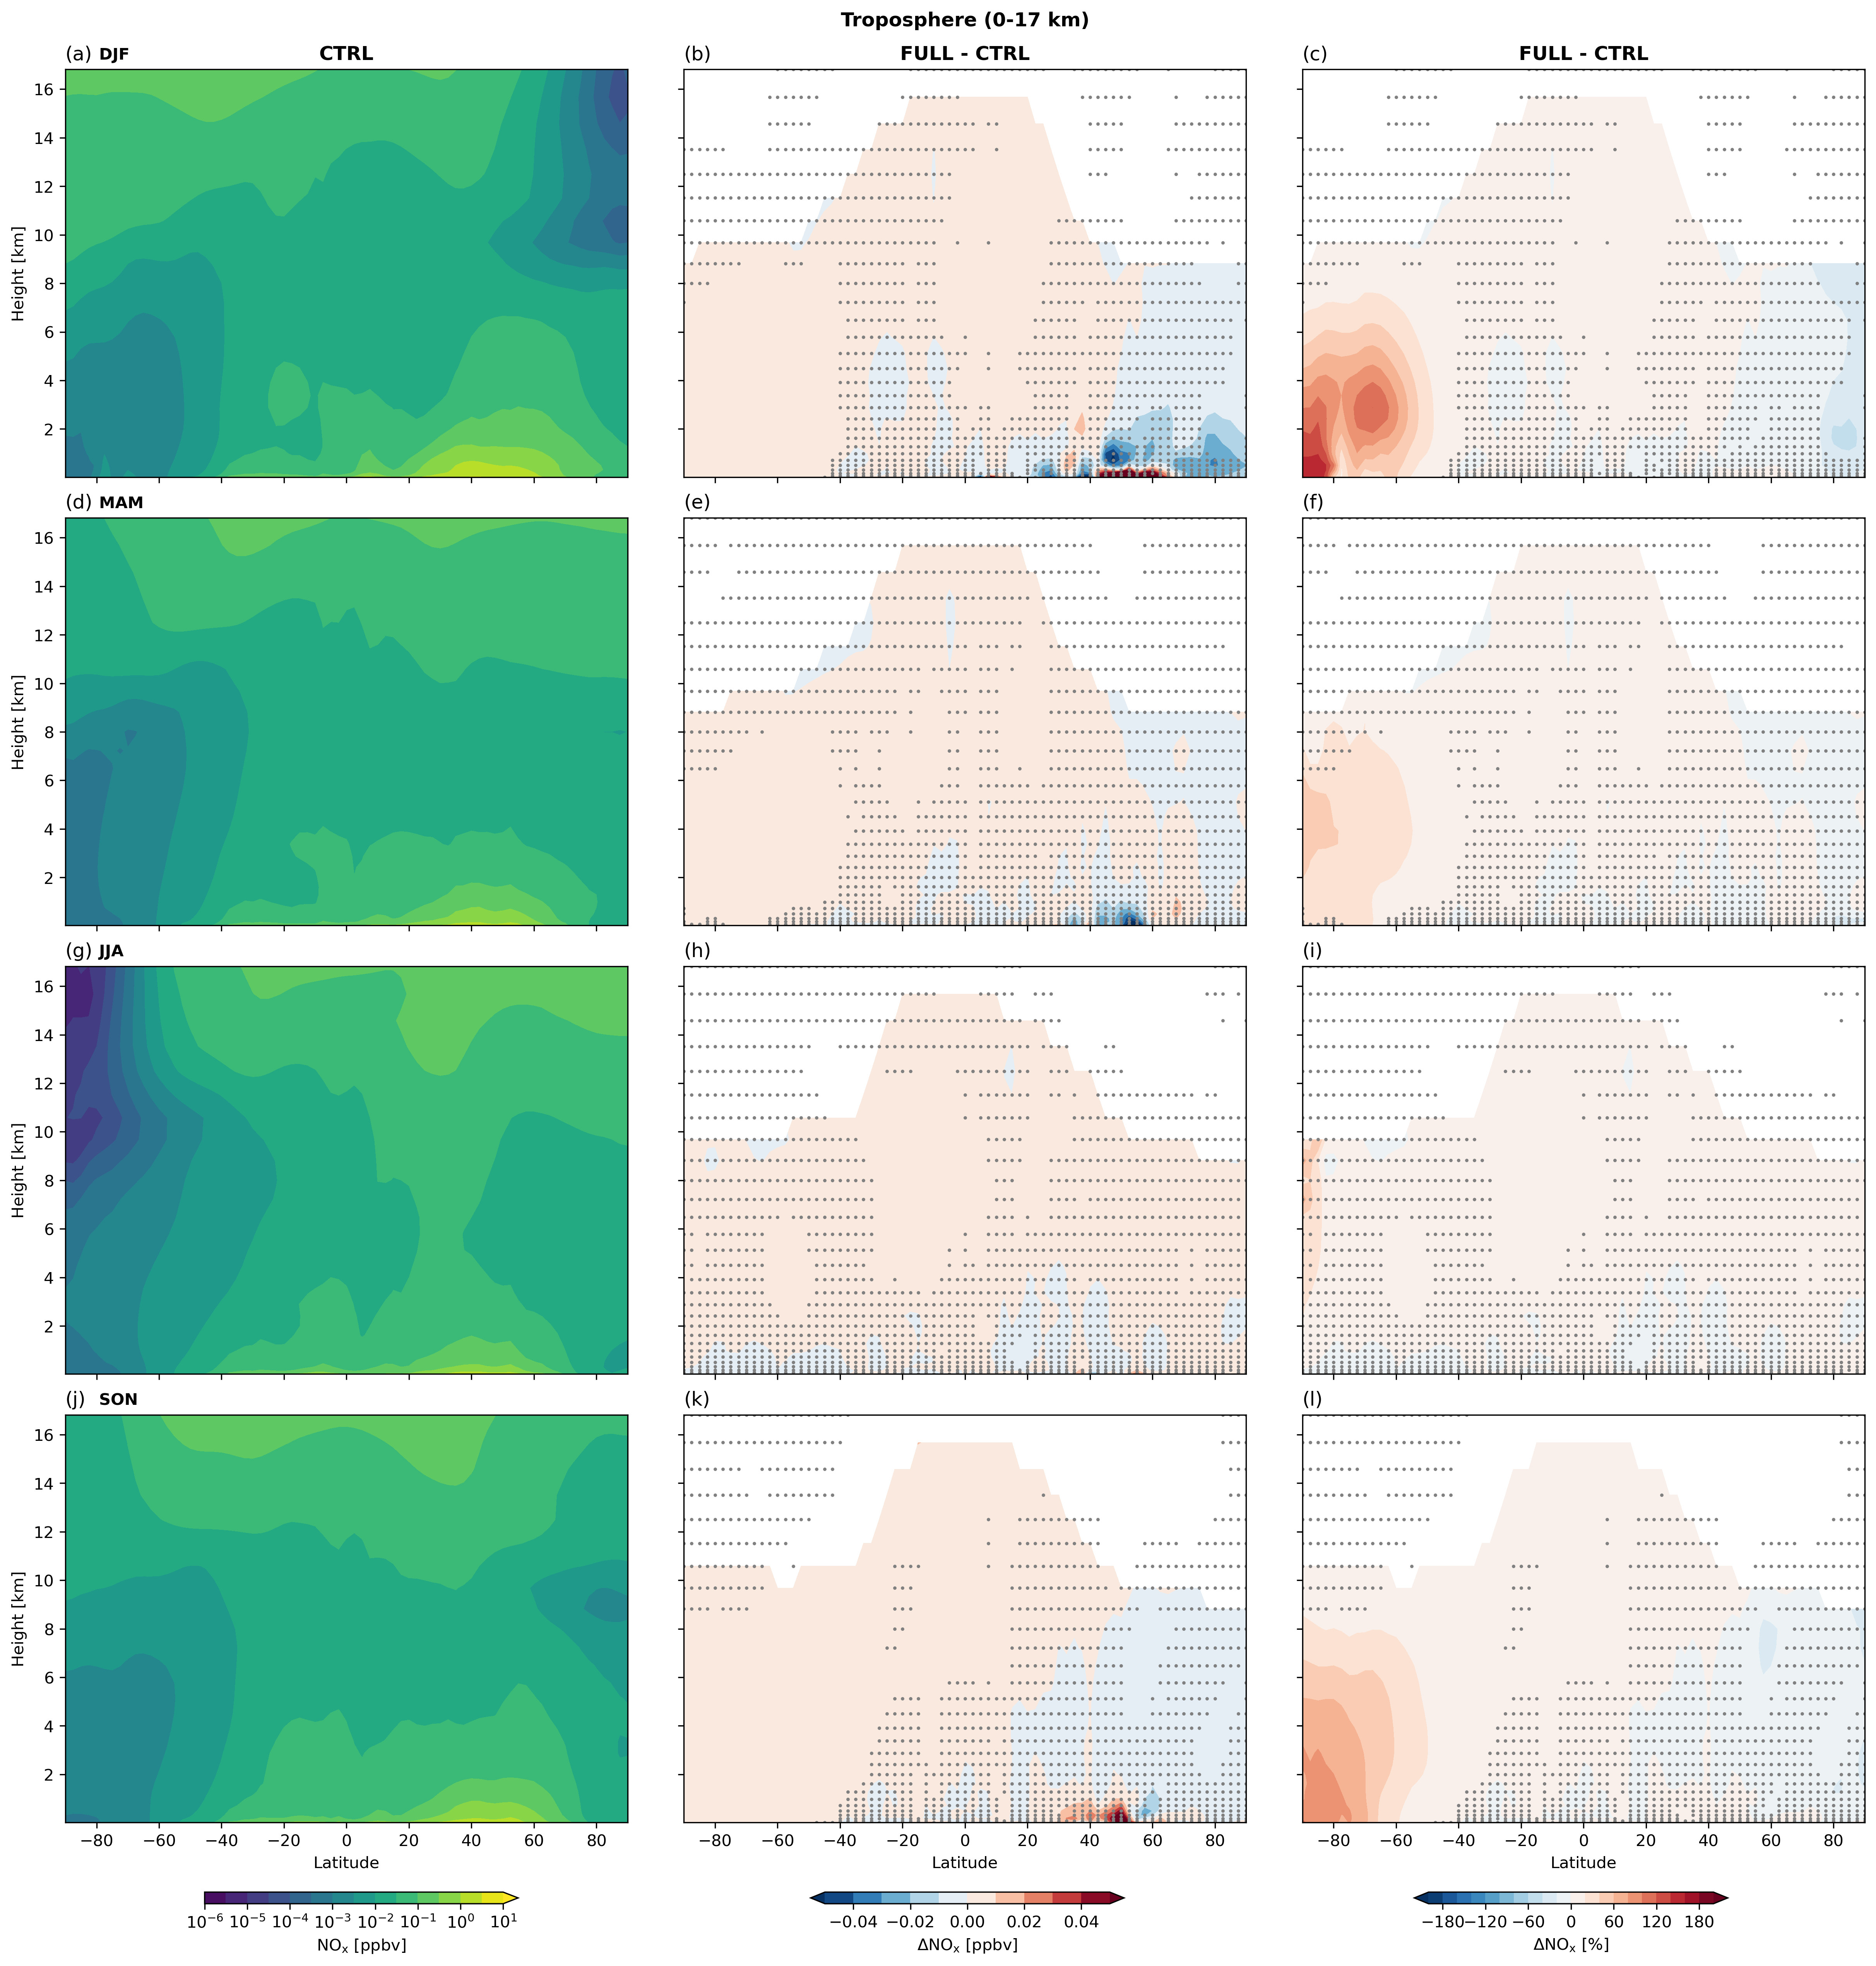

In [290]:
ctrl_dict = VRBLS[ctrl]
for sens in [k for k in EXPERIMENTS.keys() if k != "CTRL"]:
    for var in ["o3", "nox"]:
        sens_dict = VRBLS[sens]
        plt_ssn_cross_section(var, layer, ctrl_dict, sens_dict)